<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219
Primer semestre - 2024

## Taller 7

**Integrante 1:** Jhon Stewar Rayo Mosquera

**Integrante 2:** Carlos Raúl de la Rosa Peredo


Este taller consta de un punto, el cual se desarrollara implementando todo lo que hemos visto en esta y las anteriores clases.

Los datos se encuentran en el siguiente enlace: https://www.dropbox.com/scl/fi/qh6dk5qch11rfuz9hmptm/Data.zip?rlkey=wdteinhhad7s6j5okq0bjosvq&dl=0

NOTA: El archivo .pynb entregado debe tener todas las celdas ejecutadas, con los resultados visibles. El nombre del archivo debe ser NombreCompleto_Taller7.ipynb

In [1]:
# for data input and output:
import numpy as np
import os
# for deep learning:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape # new!
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D #new!
from tensorflow.keras.optimizers import RMSprop # new!
# for plotting:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


2024-04-29 09:16:53.012410: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 09:16:53.053792: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 09:16:53.053823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 09:16:53.055014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 09:16:53.063103: I tensorflow/core/platform/cpu_feature_guar

In [2]:
'''
Contrumios el discriminador, el cual nos ayuda a clasificar si la imagen en cuestión es falsa o verdadera
para este ejemlo implementamos 4 capas convolucionales que van aumentando el numero de filtros de forma progresiva
al final termina con una capa densa de una neurona y activacion sigmoidal para realizar la clasificación.
'''
def build_discriminator(depth=64, p=0.3):
    # Se define las dimensiones de entrada (28,28,1)
    image = Input((28,28,1))

    #Capas convolucionales
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    conv2 = Conv2D(depth*2, 5, strides=2,padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    conv3 = Conv2D(depth*4, 5, strides=2,padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    conv4 = Conv2D(depth*8, 5, strides=1,padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))

    # Capa de salida
    prediction = Dense(1, activation='sigmoid')(conv4)

    # definición del modelo
    model = Model(inputs=image, outputs=prediction)
    return model

In [3]:
z_dimensions = 32 #Se especifica el número de dimensiones en el vector de ruido de entrada
'''
El generador es el elemento de la GAN que nos permite generar imagenes a partir de un vector de ruido
'''
def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):
    # Define inputs
    noise = Input((latent_dim,))

    '''
    La primera capa oculta es una capa densa. Esta capa permite que la entrada
    del espacio latente se mapee de manera flexible a las capas ocultas espaciales (desconvolucionales)
    que siguen. Las 32 dimensiones de entrada se asignan a 3136(7*7*64) neuronas en la capa densa, que genera una matriz
    unidimensional de activaciones. Estas activaciones luego se reforman en un mapa de activación de 7×7×64.
    '''
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # nos ayuda a normalizar las salidas de la capas
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)

    # De-Convolutional layers
    '''
    La red tiene tres capas desconvolucionales (especificadas por Conv2DTranspose).
    El primero tiene 32 filtros, y este número se reduce a la mitad sucesivamente en
    las dos capas restantes. Mientras que el número de filtros disminuye, el tamaño de
    los filtros aumenta, gracias a las capas de muestreo ascendente (UpSampling2D).
    Cada vez que se aplica upsampling (con sus parámetros predeterminados),
    tanto la altura como el ancho del mapa de activación se duplican.
    '''
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)

    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)

    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
    # Model definition
    model = Model(inputs=noise, outputs=image)
    return model

In [4]:
'''
El modelo adversario esta compuesto por ambos el discriminador y el generador
'''
def build_adversarial_model(generator, discriminator, latent_dim=z_dimensions):
    '''
    Usamos Input() para definir la entrada z del modelo, que será una matriz de ruido aleatorio de longitud 32.
    '''
    z = Input(shape=(latent_dim,))

    '''Pasar z al generador devuelve una salida de imagen de 28 × 28.'''
    img = generator(z)

    ''' Al momento de entrenar el generador, los parámetros del discriminador
    deben congelarse, por lo que establecemos
    el atributo entrenable del discriminador en Falso.'''
    discriminator.trainable = False

    '''Pasamos la imagen falsa a la red discriminadora congelada,
    que emite una predicción sobre si la imagen es real o falsa.'''
    pred = discriminator(img)

    '''utilizando la clase Model, construimos
    el modelo adversario. Al indicar que la entrada del modelo adversario
    es z y su salida es la prediccion(pred), al final se determina que la red adversaria
    consiste en que el generador pasa img al discriminador congelado.'''
    adversarial_model = Model(z, pred)

    adversarial_model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0004), metrics=['accuracy'])
    
    return adversarial_model

In [5]:
'''
Cargamos el dataset
'''
def load_dataset(dataset):
    # Load the dataset into memory
    data = np.load(dataset)
    
    # Normalize the input data
    data = data/255
    data = np.reshape(data, (data.shape[0], 28, 28, 1))
    
    # Display a sample image from the input
    plt.title('sample image from dataset')
    plt.imshow(data[241,:,:,0], cmap='Greys')
    plt.show()
    
    return data

## Modelo

Escogimos el dataset de `dolphin.npy` y `guitar.npy` obtenido de quickdraw(https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap;tab=objects?prefix=&forceOnObjectsSortingFiltering=false) el cual se crea a partir de imagenes dibujadas por usuarios en la aplicacion quickdraw de google(https://quickdraw.withgoogle.com/)

In [6]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0008), metrics=['accuracy'])
discriminator.summary()

2024-04-29 09:16:54.979167: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)         0     

2024-04-29 09:16:55.013291: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 09:16:55.013442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 09:16:55.014271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
generator = build_generator()
#observar las dimensiones de salida despues de cada capa
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              103488    
                                                                 
 batch_normalization (Batch  (None, 3136)              12544     
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                           

In [8]:
#Para probar el generados creamos un vetor de ruido con distrubucion normal
#lo ingresamos al generador
noise_vector = np.random.normal(size=(z_dimensions,1))
noise_image = generator.predict(noise_vector.T)

2024-04-29 09:17:01.195956: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-29 09:17:01.347770: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-29 09:17:01.445196: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 1s 946ms/step


Dimensiones antes de implementar squeeze: (1, 28, 28, 1)
Dimensiones despues de implementar squeeze: (28, 28)




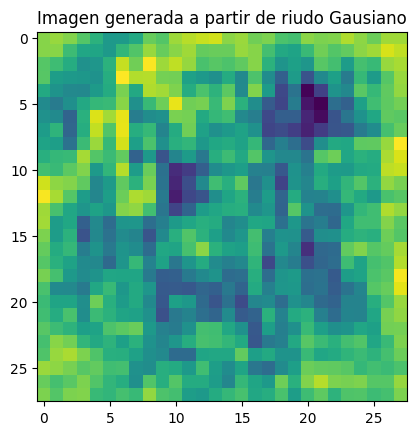

In [9]:
#Mostra la imagen que se genera a parir del ruido
# squeeze procesa el tensor y quita las dimensiones iguales a 1 como se muestra a continuación:
print(f'Dimensiones antes de implementar squeeze: {noise_image.shape}')
print(f'Dimensiones despues de implementar squeeze: {noise_image.squeeze().shape}')
print('\n')
plt.imshow(noise_image.squeeze())
plt.title('Imagen generada a partir de riudo Gausiano')
plt.show()

In [10]:
adversarial_model = build_adversarial_model(generator, discriminator)
adversarial_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         183713    
                                                                 
 model (Functional)          (None, 1)                 4311553   
                                                                 
Total params: 4495266 (17.15 MB)
Trainable params: 177329 (692.69 KB)
Non-trainable params: 4317937 (16.47 MB)
_________________________________________________________________


In [11]:
epochs = 3000

'''
Construimos el modelo generador/discriminador
'''
def train_model(data, datasetname, epochs=epochs, batch=64, z_dim=z_dimensions):
    d_metrics = []
    a_metrics = []
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    for i in range(epochs):
        # print(i)
        # Muestra un batch de 64 imágenes reales seleccionadas de forma aleatoria, se ñe hace un reshape.
        real_imgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch,28,28,1))

        '''Generar 64(batch) imágenes falsas creando vectores de ruido (z, muestreados uniformemente en el rango [–1:0, 1:0])
         y pasándolos al método 'predict' del modelo generador. Tenga en cuenta que al usar el método de predicción,
          el generador solo está generando imágenes sin actualizar ninguno de sus parámetros.'''
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]), verbose=0)

        '''Se concatenan las imágenes reales y falsas en una sola variable x, que servirá como entrada en nuestro discriminador.'''
        x = np.concatenate((real_imgs,fake_imgs))

        ''' Cree una matriz, y, para etiquetar las imágenes como reales (y = 1) o falsas (y = 0)
        para que puedan usarse para entrenar al discriminador.'''
        y = np.ones([2*batch,1]) # se usa 2*batch ya que son 64(1 batch) reales y 64(1 batch) falsas
        y[batch:,:] = 0 # se agrga la etiqueta 0 a las imagenes falsas

        # train discriminator:
        '''Para entrenar al discriminador, pasamos nuestras entradas X y etiquetas Y al método train_on_batch del modelo.'''
        d_metrics.append(discriminator.train_on_batch(x,y)) #train_on_batch : Ejecuta una única actualización de gradiente en un único batch de datos.
        '''Después de cada ronda de entrenamiento, las métricas de loss
        y accuracy del entrenamiento se agregan a la lista d_metrics'''
        running_d_loss += d_metrics[-1][0] #Se suman los valores de perdida en cada epoca del discriminador
        running_d_acc += d_metrics[-1][1] #Se suman los valores de accuracy en cada epoca del discriminador

        # adversarial net's noise input and "real" y:
        '''Se pasan vectores de ruido aleatorio como entradas,
        así como una matriz (y) de etiquetas totalmente reales (es decir, y = 1)
          al método train_on_batch del modelo contradictorio.'''
        noise = np.random.uniform(-1.0, 1.0, size=[batch, z_dim])
        y = np.ones([batch,1])

        # train adversarial net:
        '''El componente generador del modelo adversario convierte las entradas
        de ruido en imágenes falsas, que se pasan automáticamente como entradas al
        componente discriminador del modelo adversario. Debido a que los parámetros
        del discriminador se congelan durante el entrenamiento del modelo adversario,
        el discriminador simplemente nos dirá si cree que las imágenes entrantes son
        reales o falsas. Aunque el generador genera falsificaciones, se etiquetan
        como reales (y = 1) y cross-entropy loss se usa durante la retropropagación
        para actualizar los pesos del modelo del generador. Al minimizar este costo,
        el generador debe aprender a producir imágenes falsas que el discriminador
        clasifica erróneamente como reales.'''
        a_metrics.append(adversarial_model.train_on_batch(noise,y))

        running_a_loss += a_metrics[-1][0] #Se suman los valores de perdida en cada epoca de la red adversa
        running_a_acc += a_metrics[-1][1] #Se suman los valores de accuracy en cada epoca de la red adversa

        # periodically print progress & fake images:
        if (i+1)%200== 0:
            #Se imprimen los valores de las metricas
            print(f'Epoch #{i}')
            log_mesg = f"{i}: [D loss: {(d_metrics[-1][0]):.7f}, acc:{(d_metrics[-1][1]):.7f}]"
            log_mesg = f"{log_mesg} [A loss: {(a_metrics[-1][0]):.7f}, acc: {(a_metrics[-1][1]):.7f}]"
            print(log_mesg)

            #Se generan 16 imagenes a partir de vectores de riudo usando el generador previamente entrenado
            noise = np.random.uniform(-1.0, 1.0, size=[16, z_dim])
            gen_imgs = generator.predict(noise)
            plt.figure(figsize=(7,7))
            plt.title(f'Imagenes generadas epoca #{i}')

            for k in range(gen_imgs.shape[0]):
                #plt.figure(figsize=(7,7))
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
            plt.tight_layout()

            plt.savefig(f'{datasetname}/images_epoch_{i}.png') #guardamos las imagenes
            plt.show()

            generator.save(f'chkpt/{datasetname}/generator_epoch_{i}.h5') #guardamos el modelo
    return a_metrics, d_metrics

In [12]:
def show_metrics(a, d, datasetname):
    a_metrics_full = np.array(a)
    d_metrics_full = np.array(d)
    # Graficar el comportamiento de la perdida del discriminador y la red adversa a traves de las epocas de entrenamiento
    ax = pd.DataFrame({
        'Adversarial': [metric[0] for metric in a_metrics_full],
        'Discriminator': [metric[0] for metric in d_metrics_full]}).plot(title='Training Loss', logy=True)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    plt.show()

In [13]:
def make_prediction(datasetname, epochs):
    #cargamos el modelo pre-entrenado previamente y realizamos una predicción
    gene  = tf.keras.models.load_model(f'chkpt/{datasetname}/generator_epoch_{epochs - 1}.h5')
    noise = np.random.uniform(-1.0, 1.0, size=(1,32))
    
    #observamos que a partir de ruido nuestro generados fue capas de recrear una donut
    plt.imshow(gene.predict(noise).squeeze(), cmap='gray')
    plt.show()

------------donut-------------


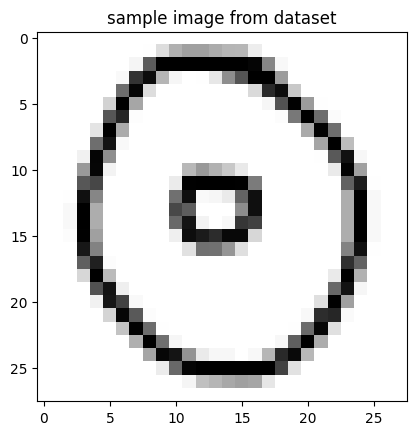

2024-04-29 09:17:03.319192: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-29 09:17:04.449717: I external/local_xla/xla/service/service.cc:168] XLA service 0x77e4f4348450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-29 09:17:04.449748: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40-24C, Compute Capability 8.6
2024-04-29 09:17:04.455042: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714400224.522362  635638 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch #199
199: [D loss: 0.0498331, acc:0.9921875] [A loss: 3.7769208, acc: 0.0156250]
1/1 [==============================] - 0s 176ms/step


/tmp/ipykernel_635601/428276689.py:78: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, k+1)


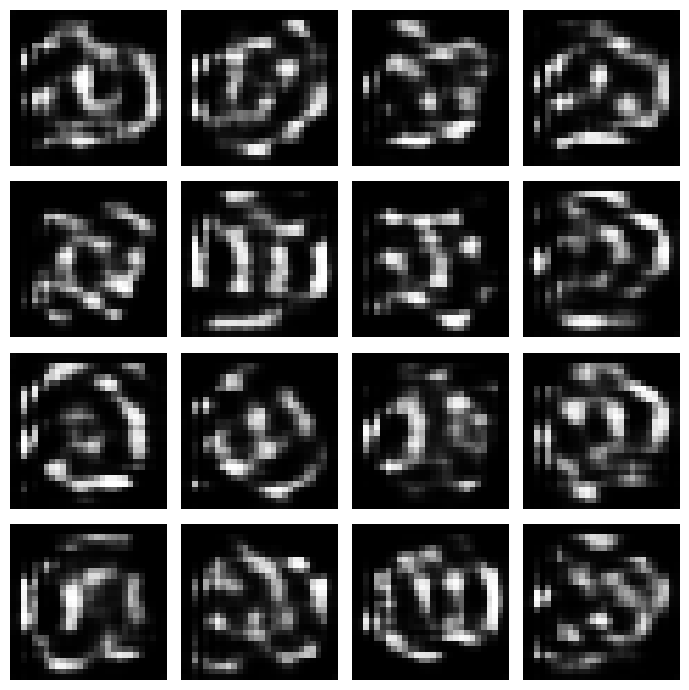

/home/estudiante/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch #399
399: [D loss: 0.5986458, acc:0.6562500] [A loss: 0.7901635, acc: 0.4843750]
1/1 [==============================] - 0s 17ms/step


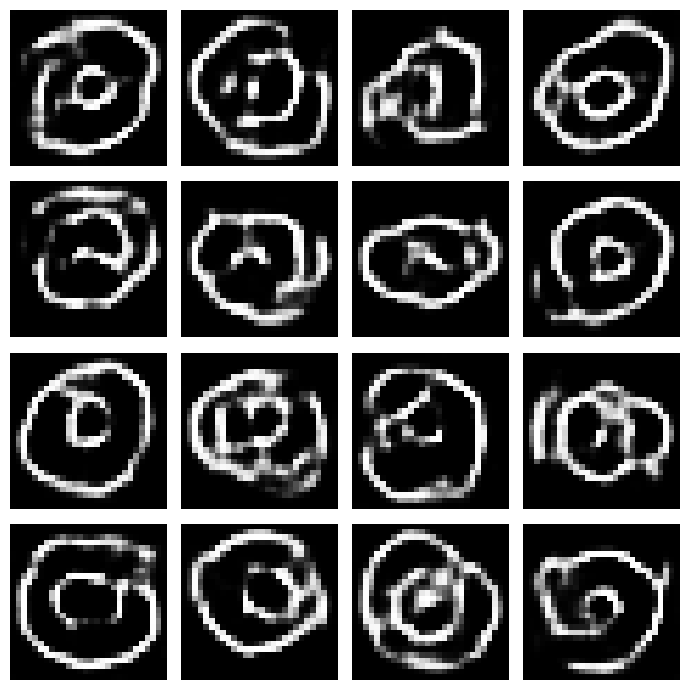

Epoch #599
599: [D loss: 0.5099276, acc:0.7734375] [A loss: 2.7275057, acc: 0.0156250]
1/1 [==============================] - 0s 17ms/step


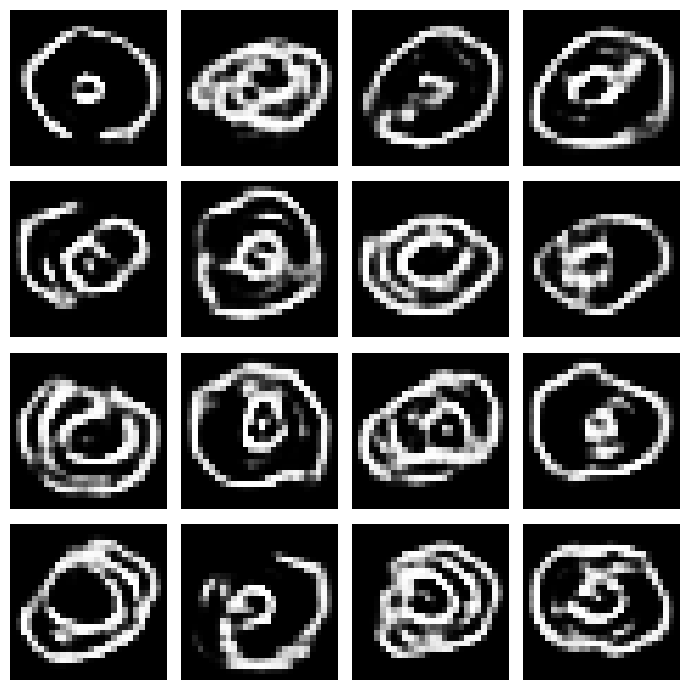

Epoch #799
799: [D loss: 0.2606158, acc:0.9140625] [A loss: 3.2422400, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


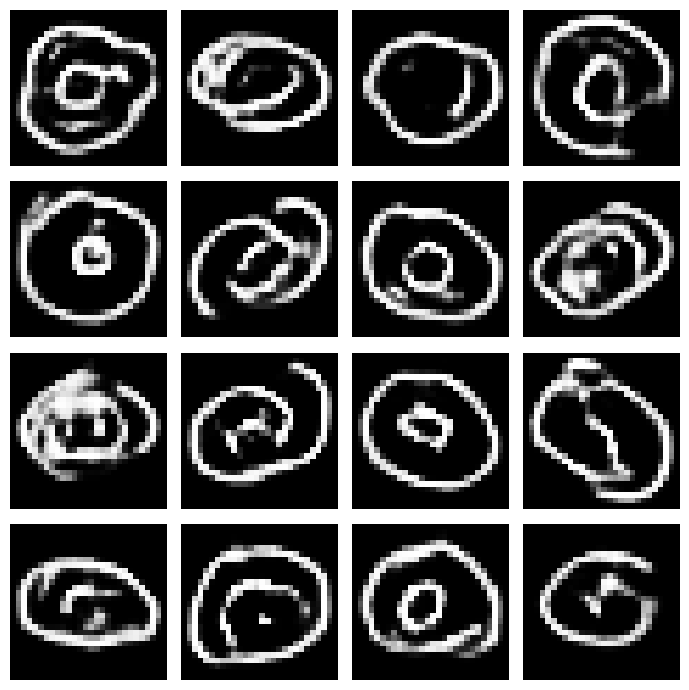

Epoch #999
999: [D loss: 0.2182603, acc:0.8906250] [A loss: 3.4540110, acc: 0.0312500]
1/1 [==============================] - 0s 17ms/step


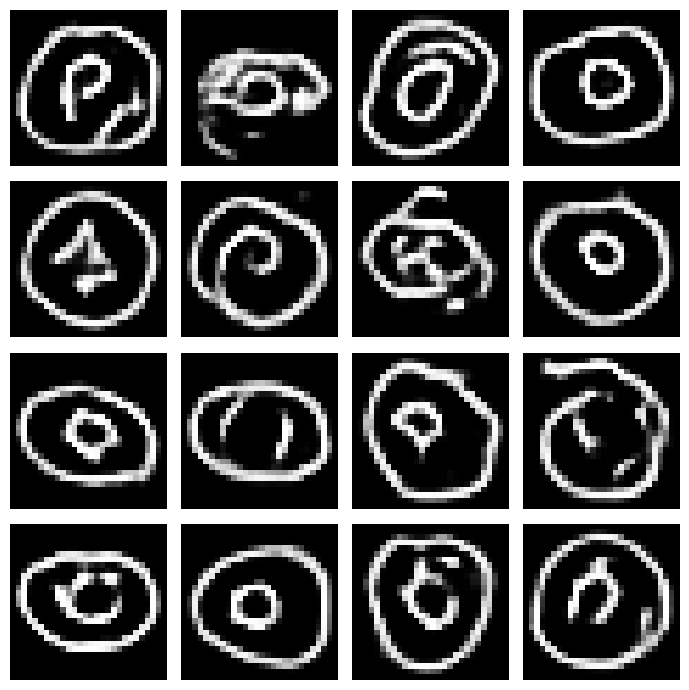

Epoch #1199
1199: [D loss: 0.3207443, acc:0.8671875] [A loss: 4.8001328, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


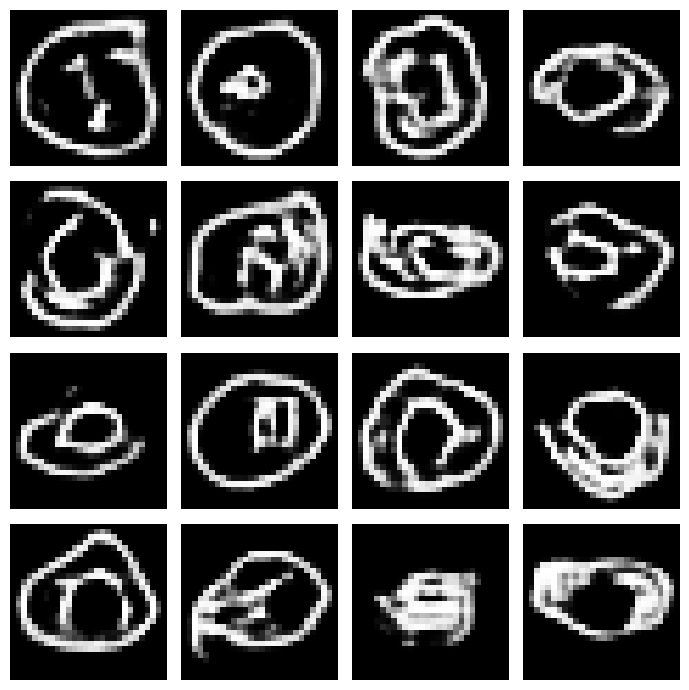

Epoch #1399
1399: [D loss: 0.3836792, acc:0.8437500] [A loss: 4.4188128, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


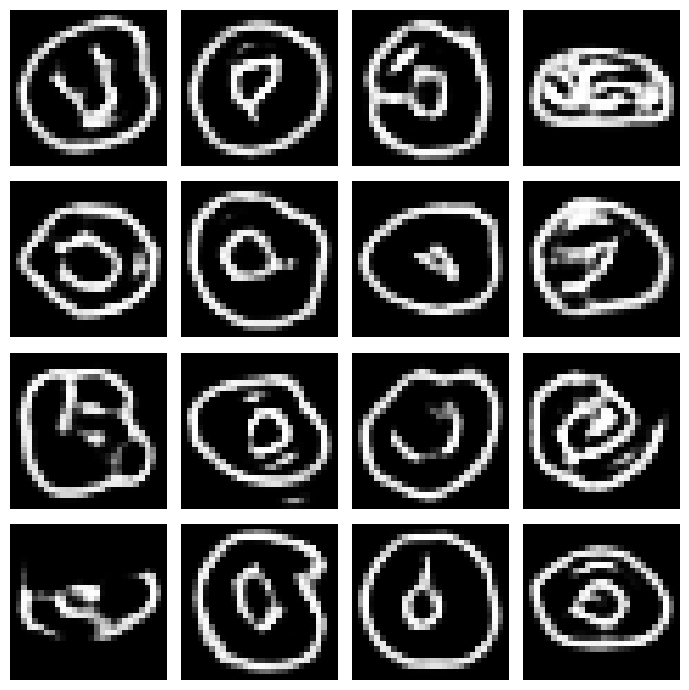

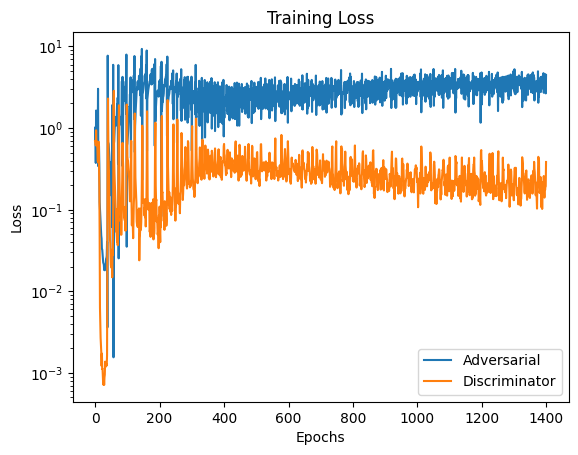

1/1 [==============================] - 0s 129ms/step


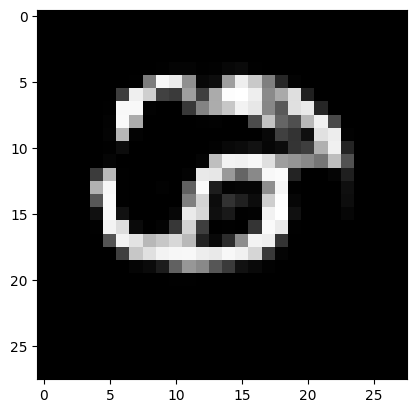

------------dolphin-------------


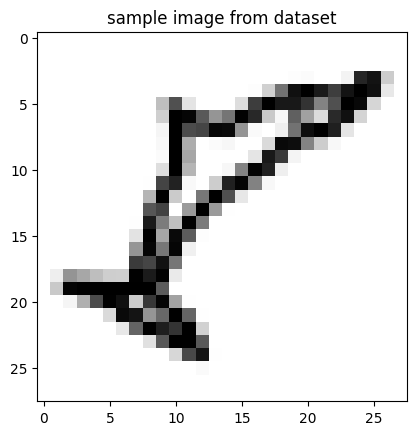

Epoch #199
199: [D loss: 0.1638287, acc:0.9140625] [A loss: 4.8622808, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


/tmp/ipykernel_635601/428276689.py:78: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, k+1)


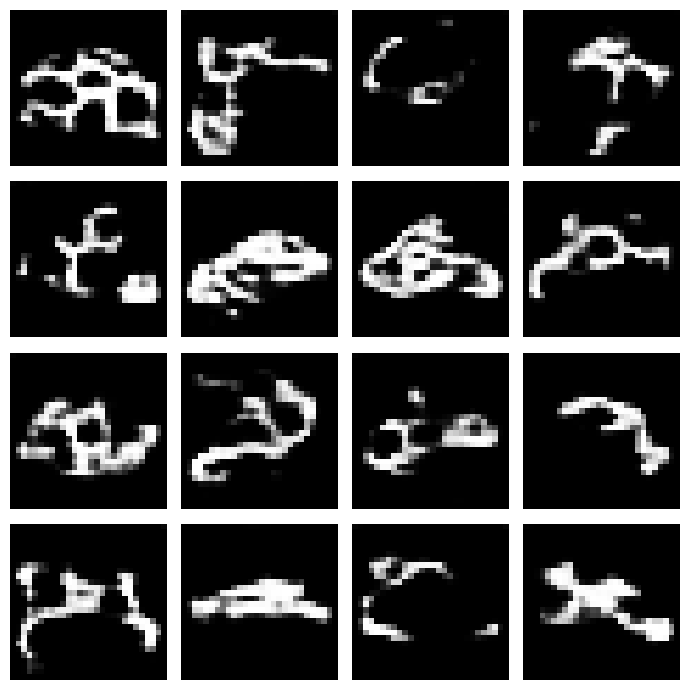

/home/estudiante/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch #399
399: [D loss: 0.1851605, acc:0.8984375] [A loss: 4.2736254, acc: 0.0156250]
1/1 [==============================] - 0s 17ms/step


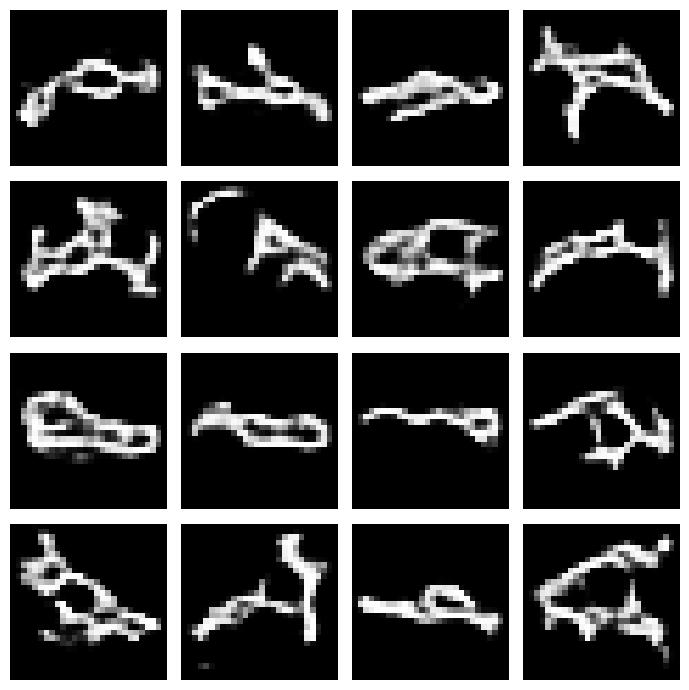

Epoch #599
599: [D loss: 0.1545804, acc:0.9296875] [A loss: 2.4531479, acc: 0.1406250]
1/1 [==============================] - 0s 17ms/step


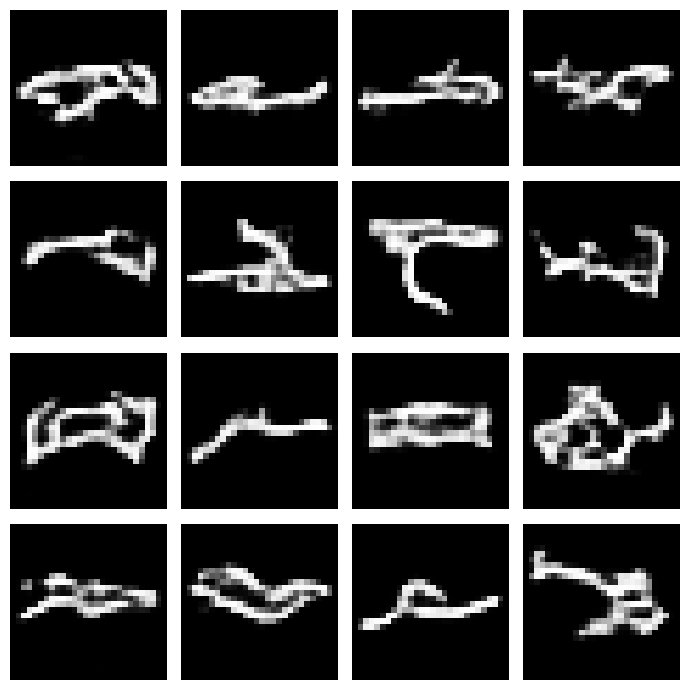

Epoch #799
799: [D loss: 0.2135763, acc:0.9296875] [A loss: 3.0038345, acc: 0.0156250]
1/1 [==============================] - 0s 17ms/step


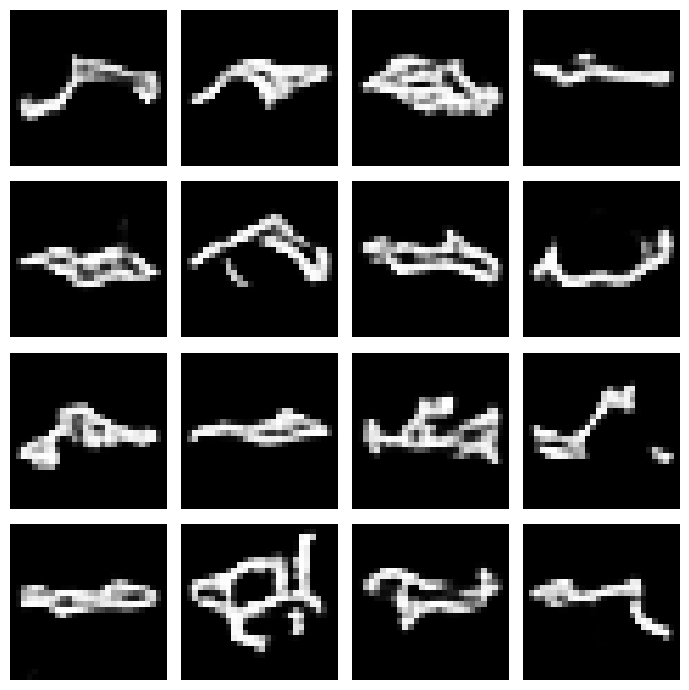

Epoch #999
999: [D loss: 0.1355183, acc:0.9531250] [A loss: 3.5141191, acc: 0.0156250]
1/1 [==============================] - 0s 17ms/step


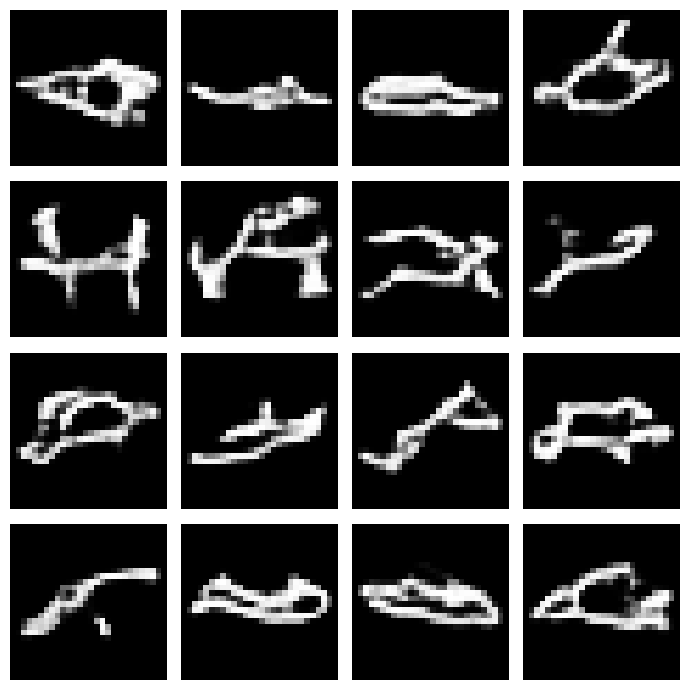

Epoch #1199
1199: [D loss: 0.1685591, acc:0.9296875] [A loss: 3.0535243, acc: 0.0937500]
1/1 [==============================] - 0s 17ms/step


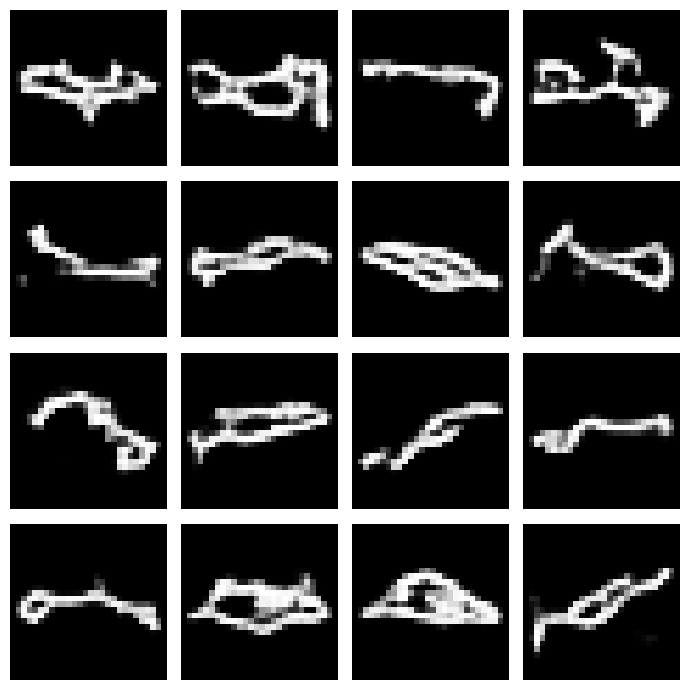

Epoch #1399
1399: [D loss: 0.0966345, acc:0.9687500] [A loss: 3.8209295, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


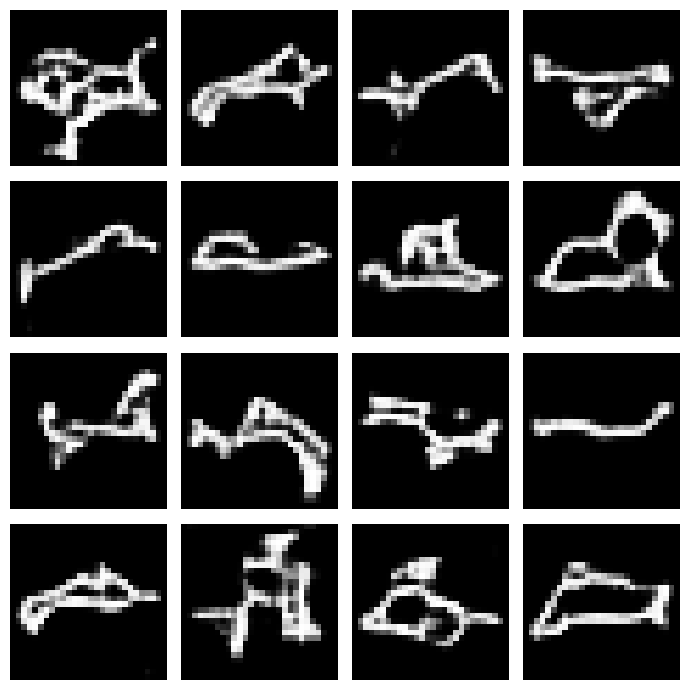

Epoch #1599
1599: [D loss: 0.1608460, acc:0.9375000] [A loss: 2.1643171, acc: 0.1562500]
1/1 [==============================] - 0s 17ms/step


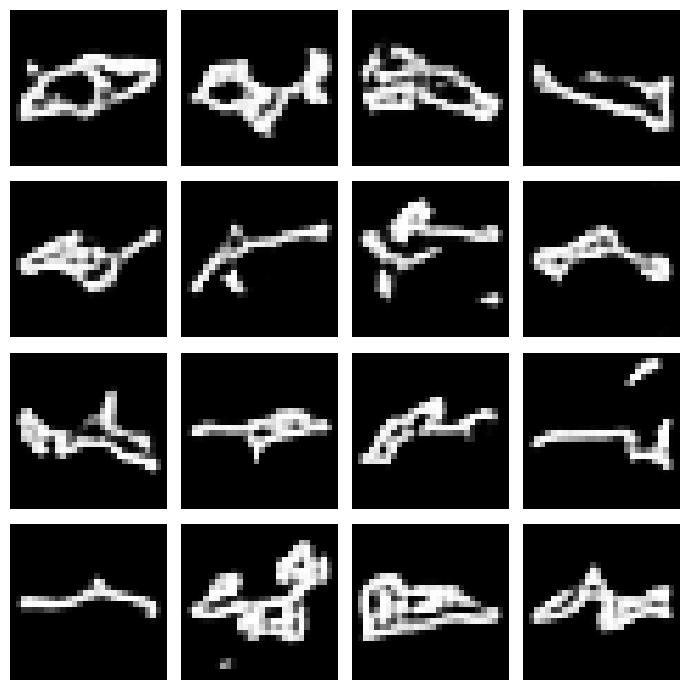

Epoch #1799
1799: [D loss: 0.1704182, acc:0.9375000] [A loss: 4.3566189, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


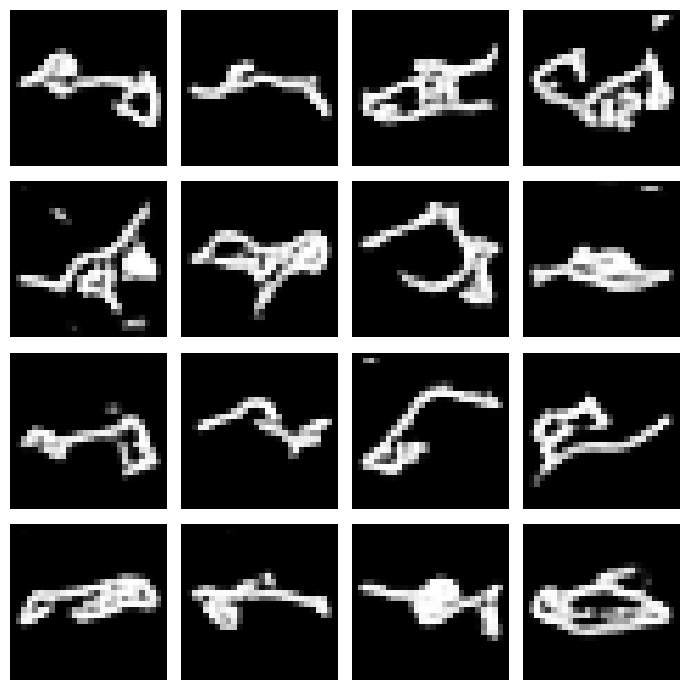

Epoch #1999
1999: [D loss: 0.1470845, acc:0.9609375] [A loss: 3.9661083, acc: 0.0156250]
1/1 [==============================] - 0s 18ms/step


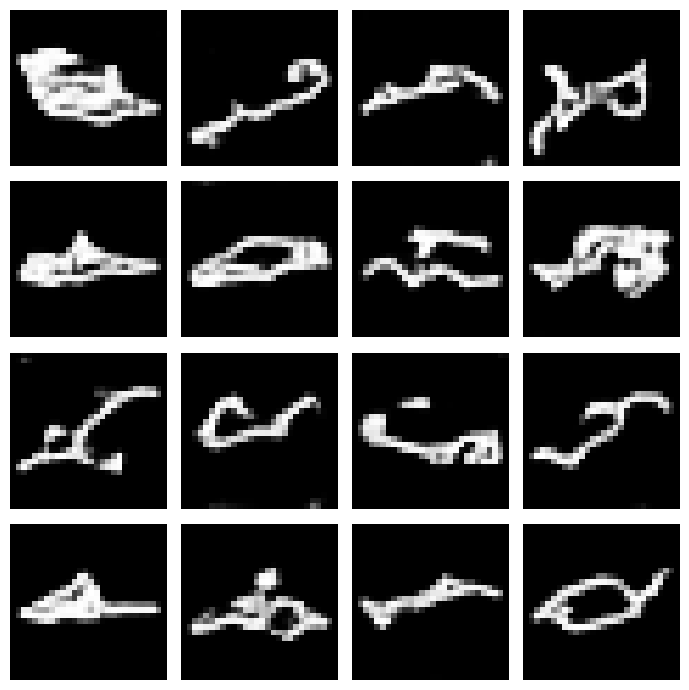

Epoch #2199
2199: [D loss: 0.1113464, acc:0.9609375] [A loss: 5.0668821, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


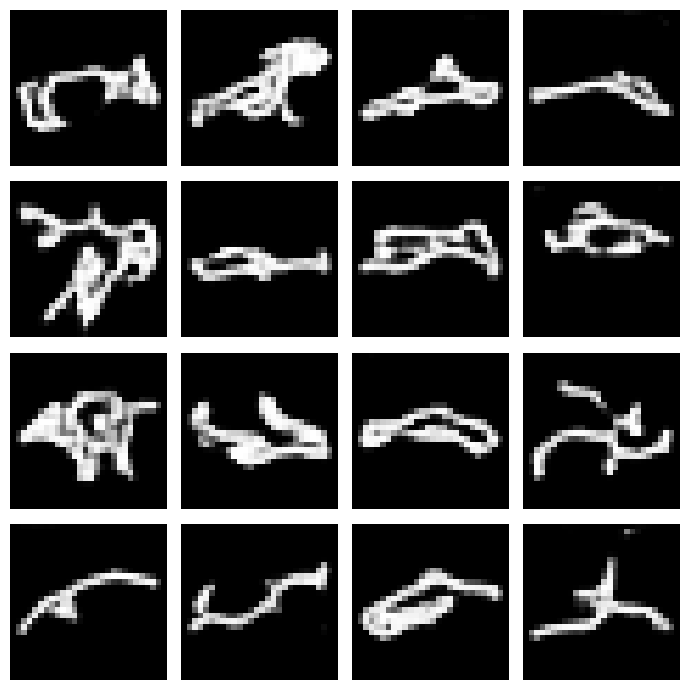

Epoch #2399
2399: [D loss: 0.2763356, acc:0.8828125] [A loss: 2.3184853, acc: 0.0468750]
1/1 [==============================] - 0s 18ms/step


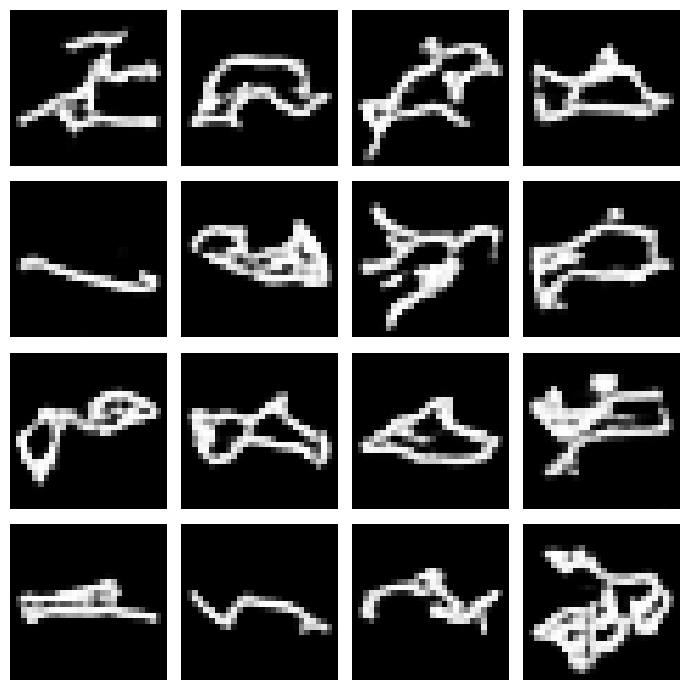

Epoch #2599
2599: [D loss: 0.1019126, acc:0.9609375] [A loss: 3.9468186, acc: 0.0156250]
1/1 [==============================] - 0s 17ms/step


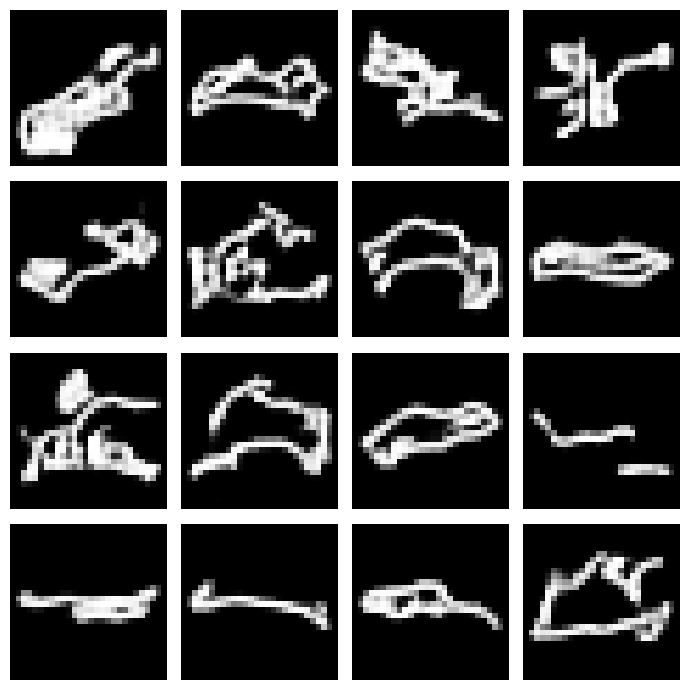

Epoch #2799
2799: [D loss: 0.1133503, acc:0.9609375] [A loss: 4.5043664, acc: 0.0000000]
1/1 [==============================] - 0s 18ms/step


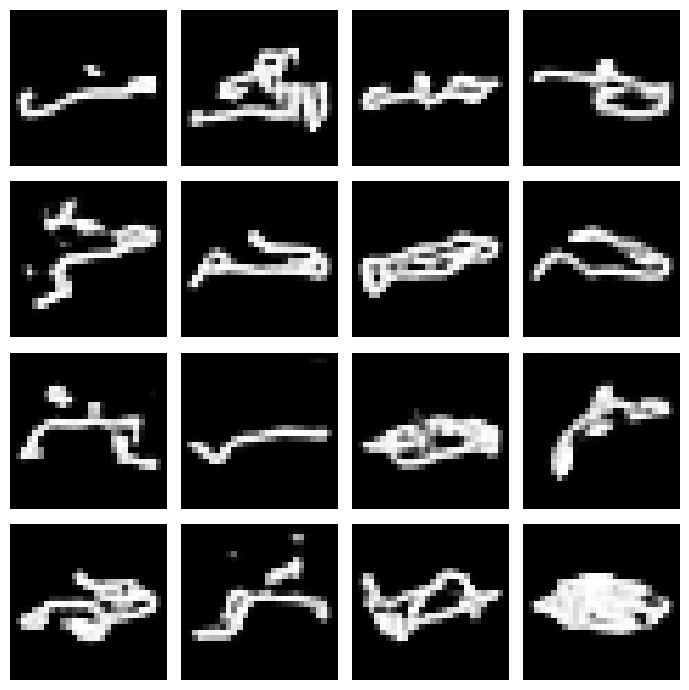

Epoch #2999
2999: [D loss: 0.1717172, acc:0.9375000] [A loss: 2.8858776, acc: 0.0937500]
1/1 [==============================] - 0s 17ms/step


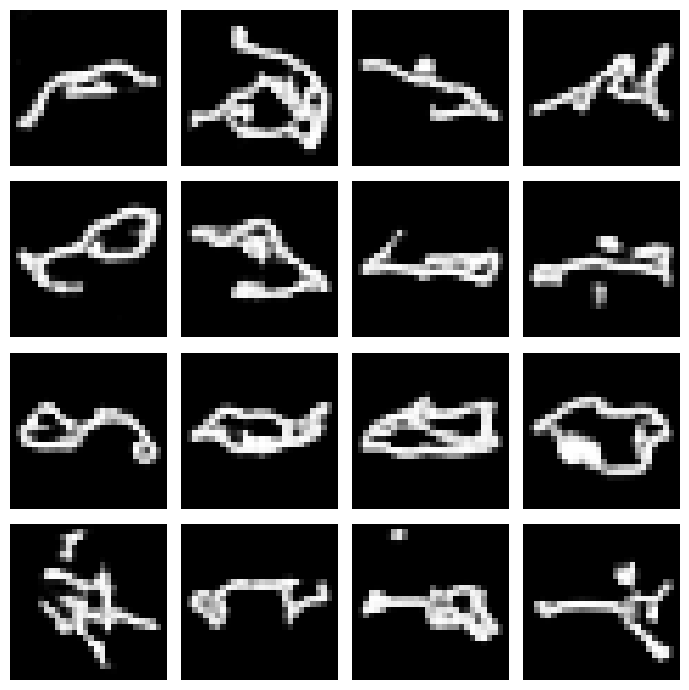

Epoch #3199
3199: [D loss: 0.1674265, acc:0.9218750] [A loss: 3.7012420, acc: 0.0000000]
1/1 [==============================] - 0s 18ms/step


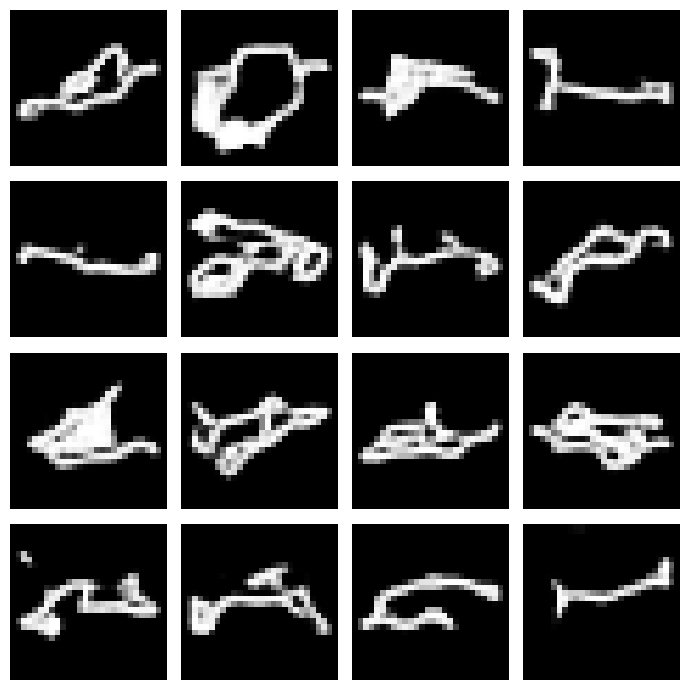

Epoch #3399
3399: [D loss: 0.1267565, acc:0.9531250] [A loss: 4.3591089, acc: 0.0156250]
1/1 [==============================] - 0s 17ms/step


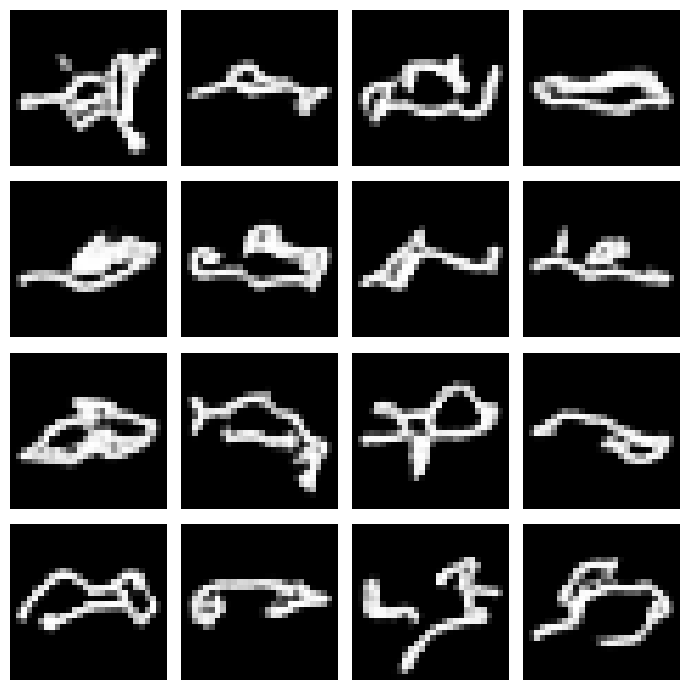

Epoch #3599
3599: [D loss: 0.1077638, acc:0.9765625] [A loss: 3.7903657, acc: 0.0312500]
1/1 [==============================] - 0s 18ms/step


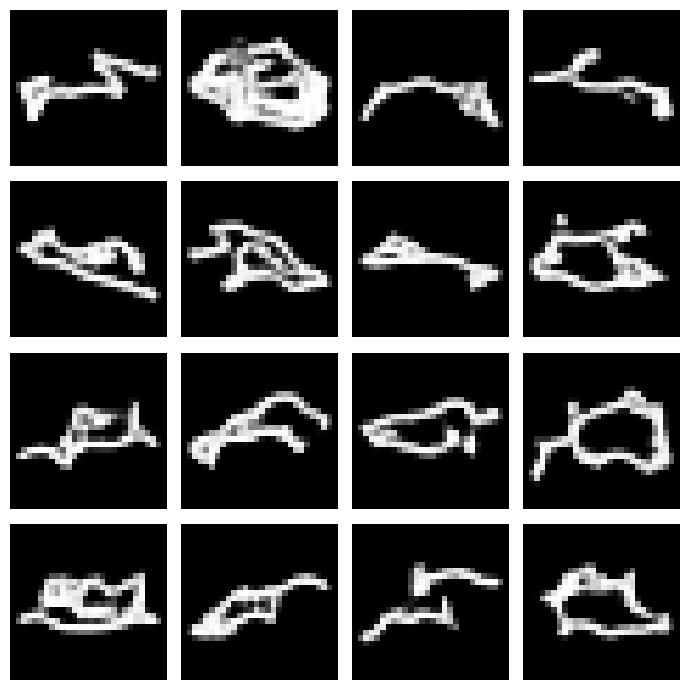

Epoch #3799
3799: [D loss: 0.2568444, acc:0.8906250] [A loss: 2.5611205, acc: 0.0781250]
1/1 [==============================] - 0s 18ms/step


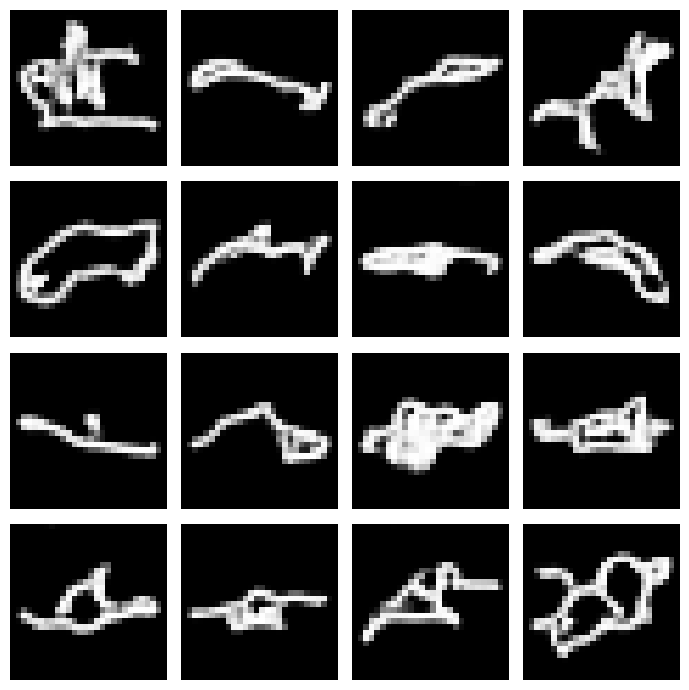

Epoch #3999
3999: [D loss: 0.3236270, acc:0.8906250] [A loss: 1.9815557, acc: 0.1093750]
1/1 [==============================] - 0s 17ms/step


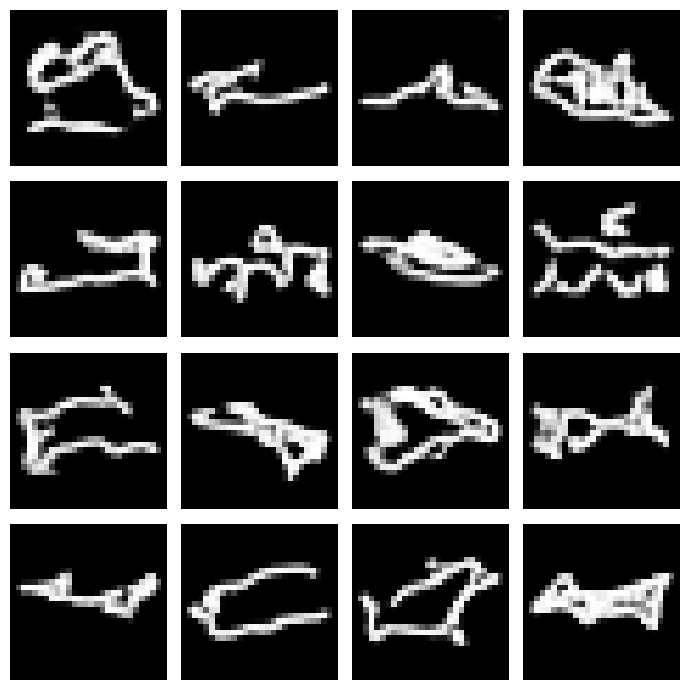

Epoch #4199
4199: [D loss: 0.0726318, acc:0.9765625] [A loss: 4.2980332, acc: 0.0000000]
1/1 [==============================] - 0s 18ms/step


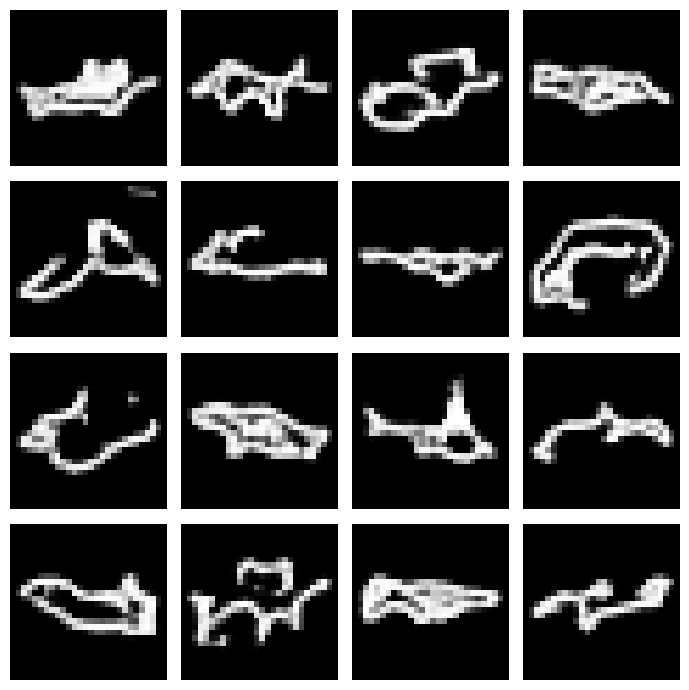

Epoch #4399
4399: [D loss: 0.1707332, acc:0.9218750] [A loss: 2.7228427, acc: 0.0468750]
1/1 [==============================] - 0s 17ms/step


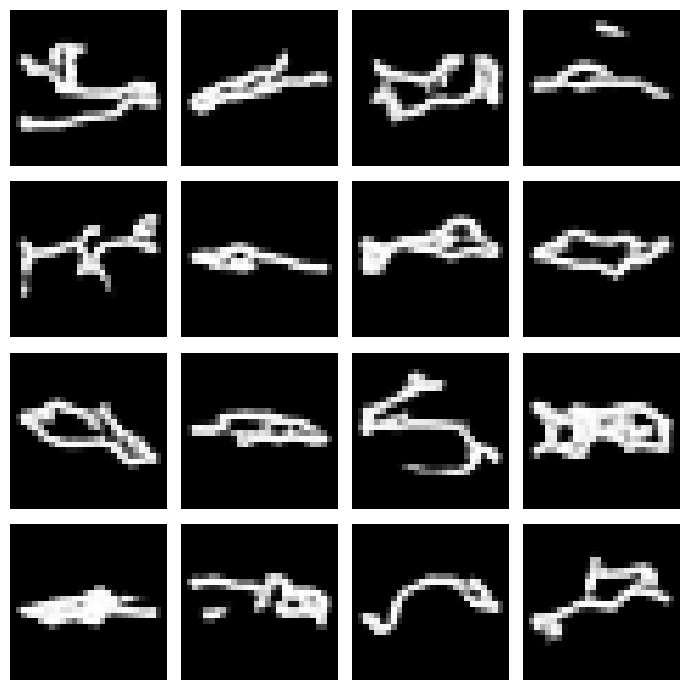

Epoch #4599
4599: [D loss: 0.1800667, acc:0.9218750] [A loss: 3.1296837, acc: 0.0468750]
1/1 [==============================] - 0s 17ms/step


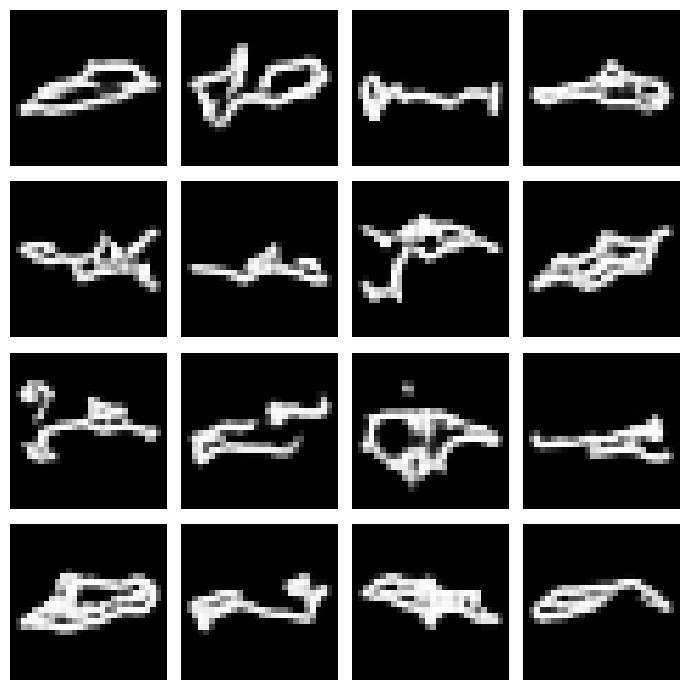

Epoch #4799
4799: [D loss: 0.1160991, acc:0.9609375] [A loss: 3.9933364, acc: 0.0468750]
1/1 [==============================] - 0s 17ms/step


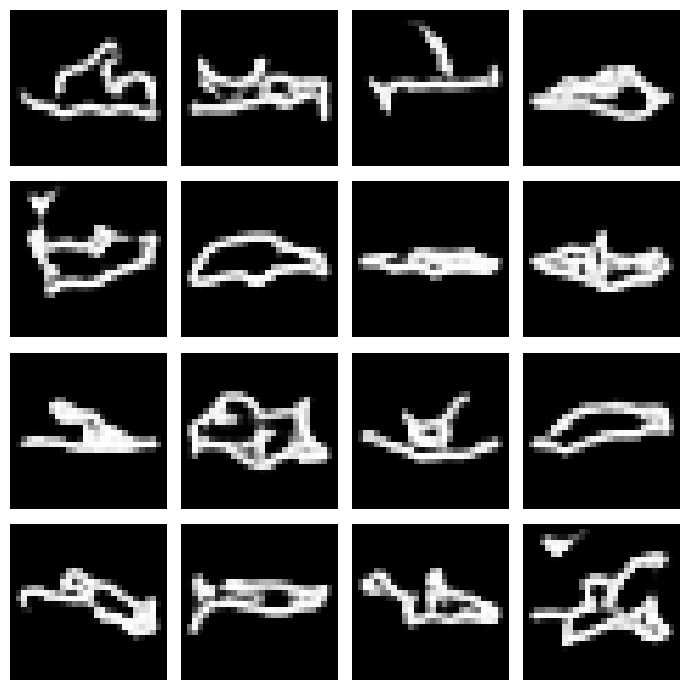

Epoch #4999
4999: [D loss: 0.2514900, acc:0.9296875] [A loss: 2.5640221, acc: 0.0625000]
1/1 [==============================] - 0s 17ms/step


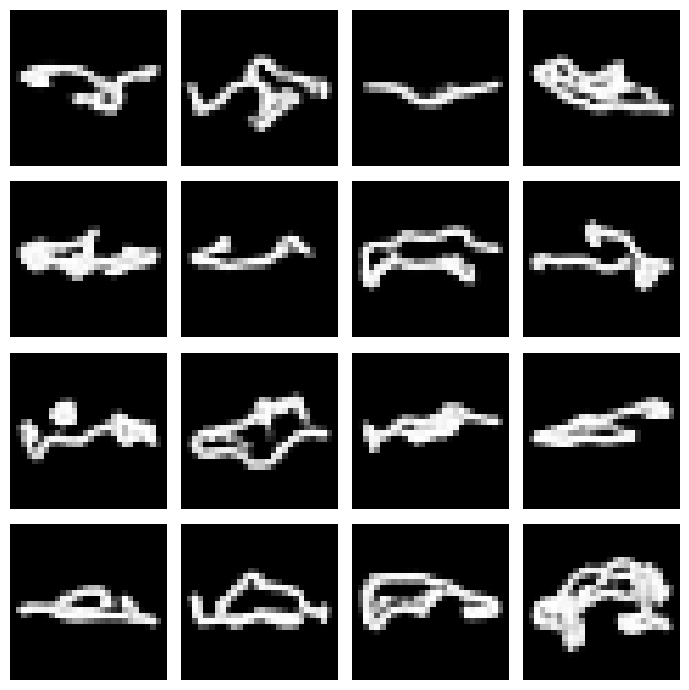

Epoch #5199
5199: [D loss: 0.1450805, acc:0.9531250] [A loss: 3.4015009, acc: 0.0312500]
1/1 [==============================] - 0s 17ms/step


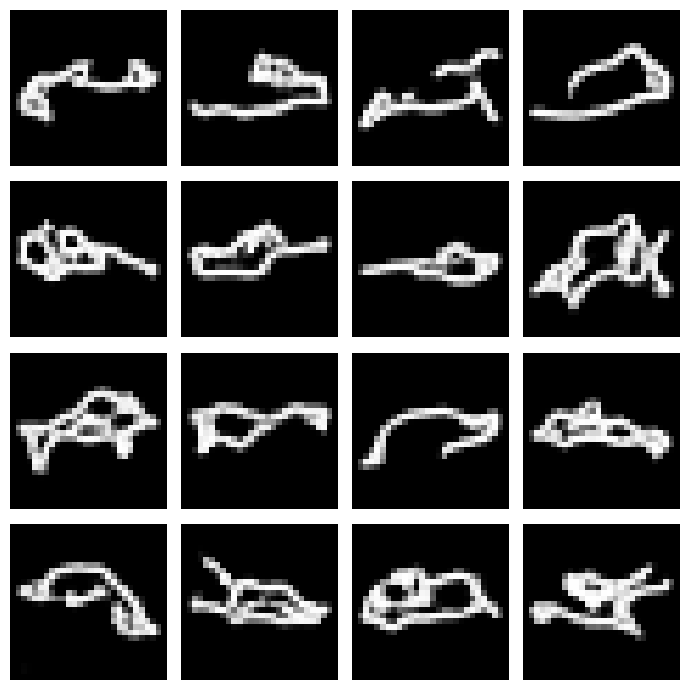

Epoch #5399
5399: [D loss: 0.1459393, acc:0.9453125] [A loss: 3.1732202, acc: 0.0937500]
1/1 [==============================] - 0s 17ms/step


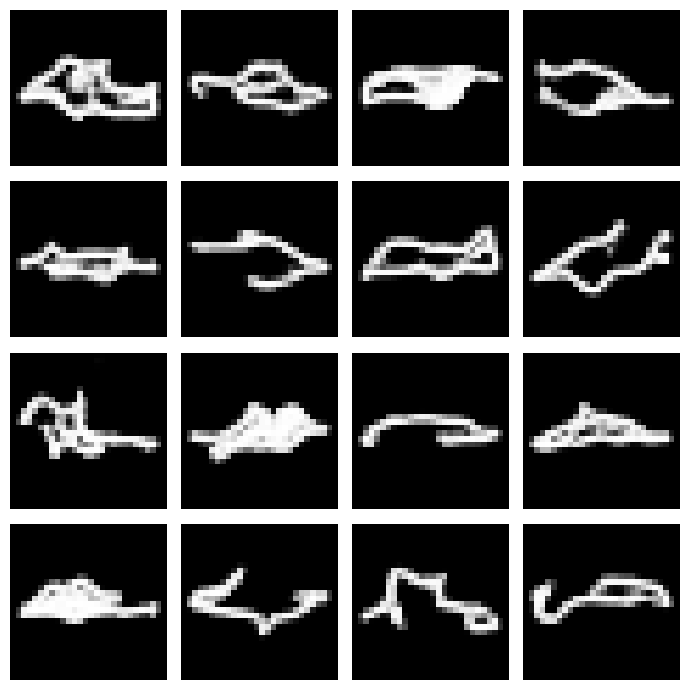

Epoch #5599
5599: [D loss: 0.1761307, acc:0.9296875] [A loss: 5.3527699, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


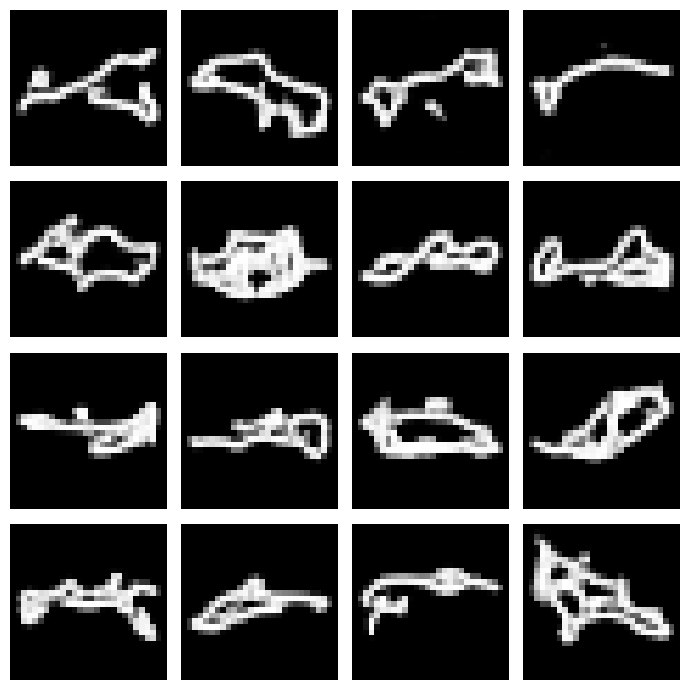

Epoch #5799
5799: [D loss: 0.1127038, acc:0.9765625] [A loss: 3.3615179, acc: 0.0312500]
1/1 [==============================] - 0s 19ms/step


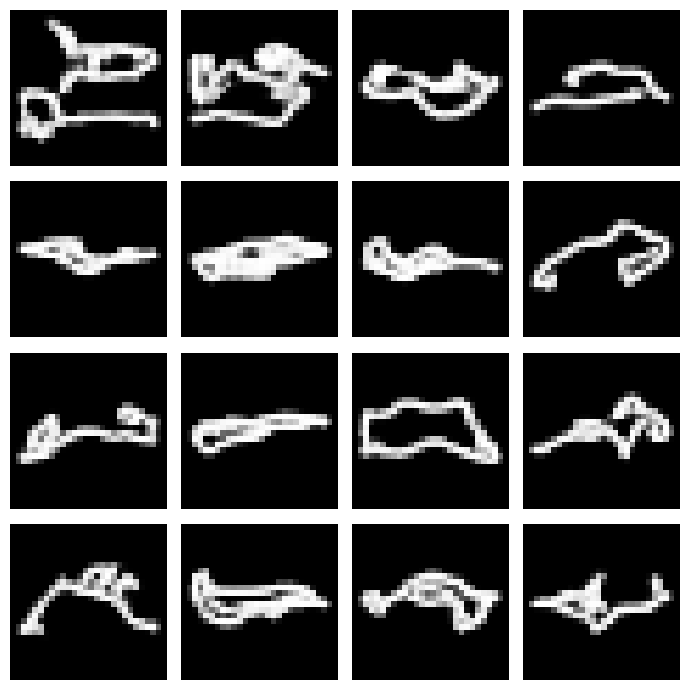

Epoch #5999
5999: [D loss: 0.0970392, acc:0.9531250] [A loss: 3.9866083, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


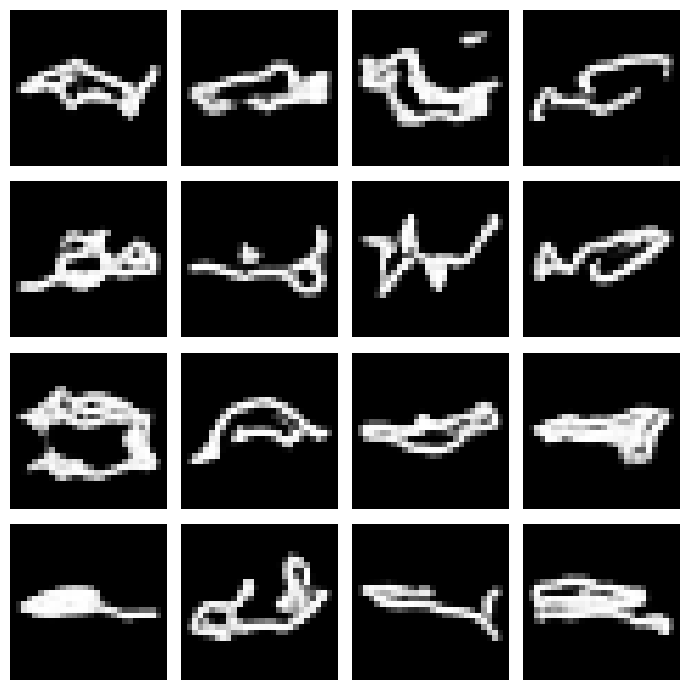

Epoch #6199
6199: [D loss: 0.1288549, acc:0.9453125] [A loss: 4.1653357, acc: 0.0468750]
1/1 [==============================] - 0s 18ms/step


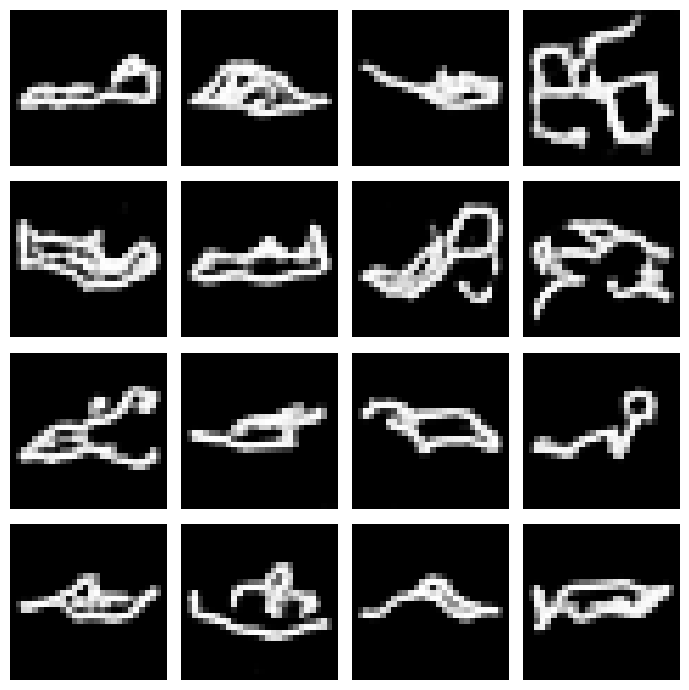

Epoch #6399
6399: [D loss: 0.2102937, acc:0.9218750] [A loss: 4.8818970, acc: 0.0000000]
1/1 [==============================] - 0s 18ms/step


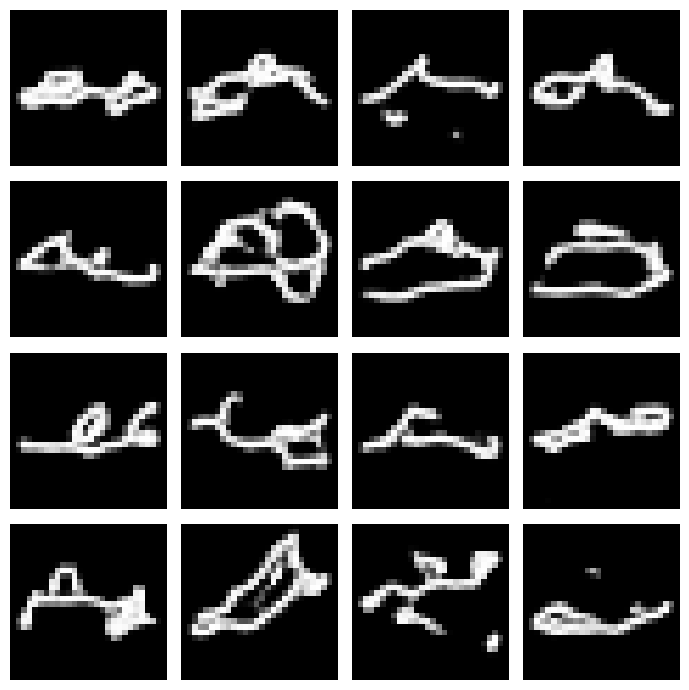

Epoch #6599
6599: [D loss: 0.1464241, acc:0.9296875] [A loss: 4.0952463, acc: 0.0312500]
1/1 [==============================] - 0s 18ms/step


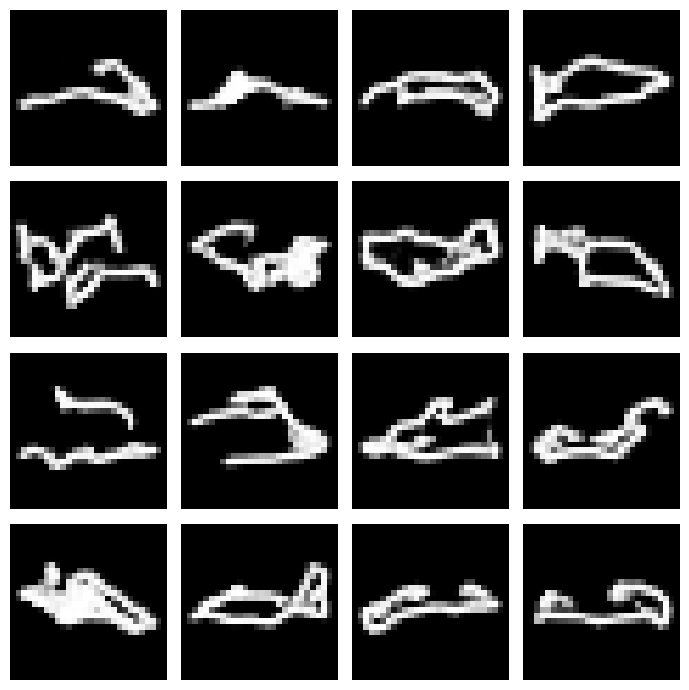

Epoch #6799
6799: [D loss: 0.0976962, acc:0.9765625] [A loss: 4.2940855, acc: 0.0156250]
1/1 [==============================] - 0s 17ms/step


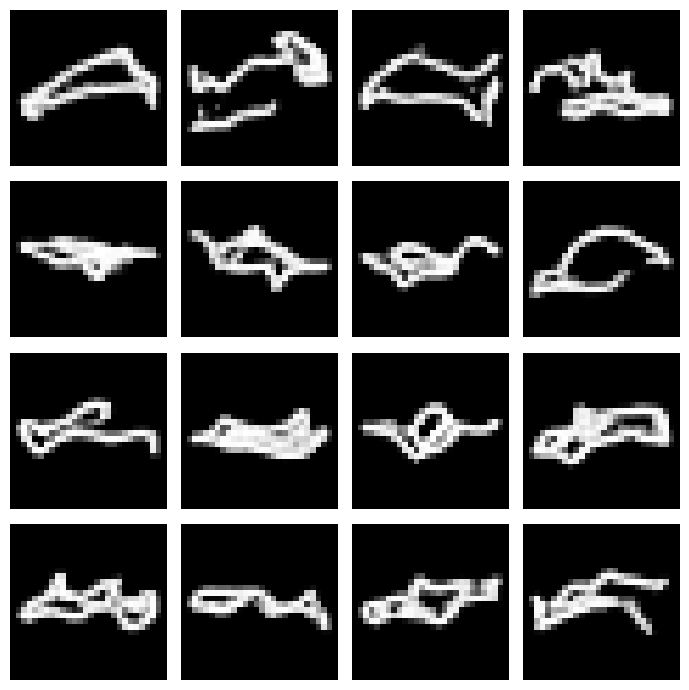

Epoch #6999
6999: [D loss: 0.1288318, acc:0.9453125] [A loss: 4.1280727, acc: 0.0156250]
1/1 [==============================] - 0s 19ms/step


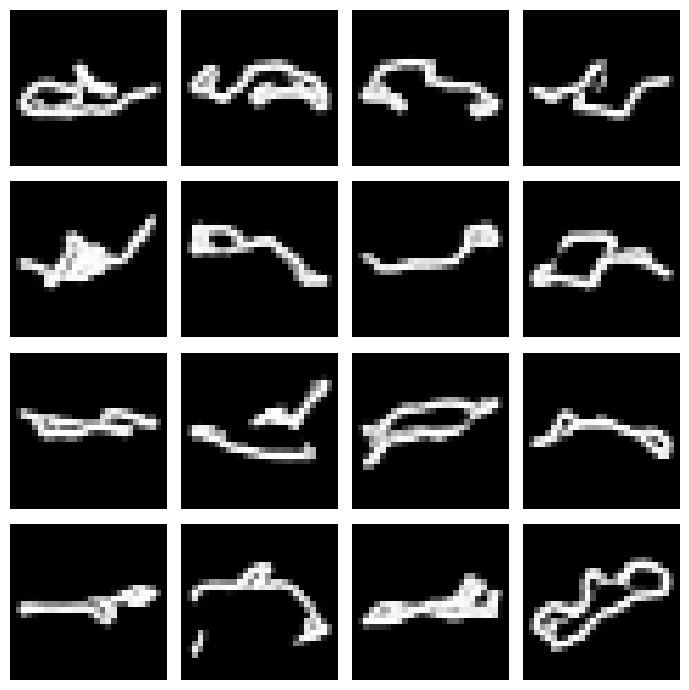

Epoch #7199
7199: [D loss: 0.1073337, acc:0.9531250] [A loss: 4.5515661, acc: 0.0312500]
1/1 [==============================] - 0s 17ms/step


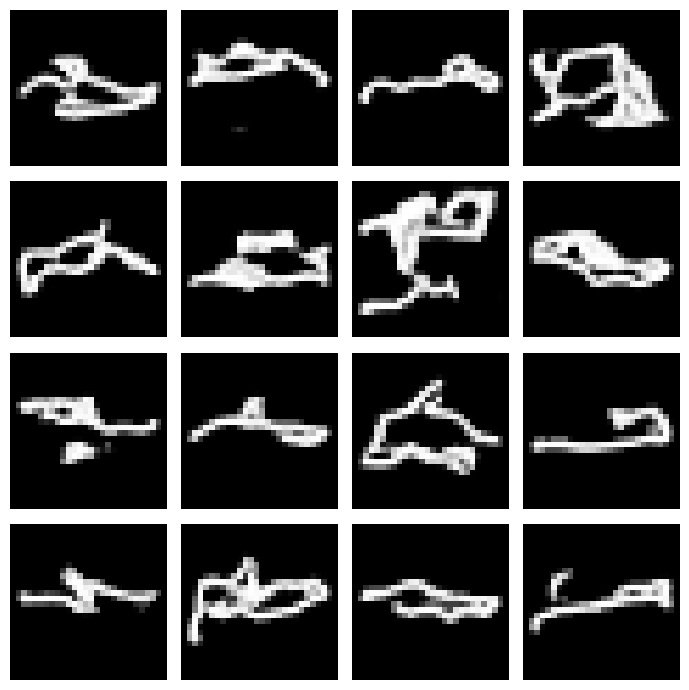

Epoch #7399
7399: [D loss: 0.2484782, acc:0.8984375] [A loss: 2.8837452, acc: 0.0625000]
1/1 [==============================] - 0s 17ms/step


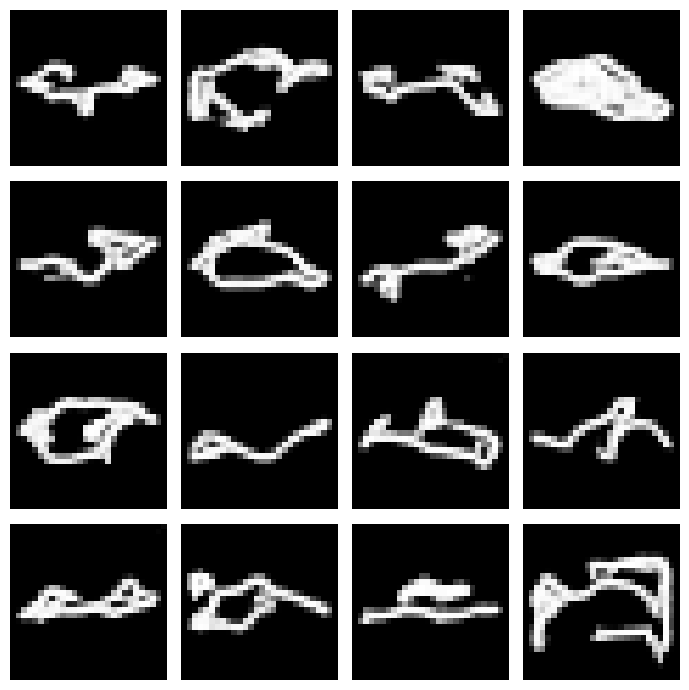

Epoch #7599
7599: [D loss: 0.3116469, acc:0.8515625] [A loss: 6.1755075, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


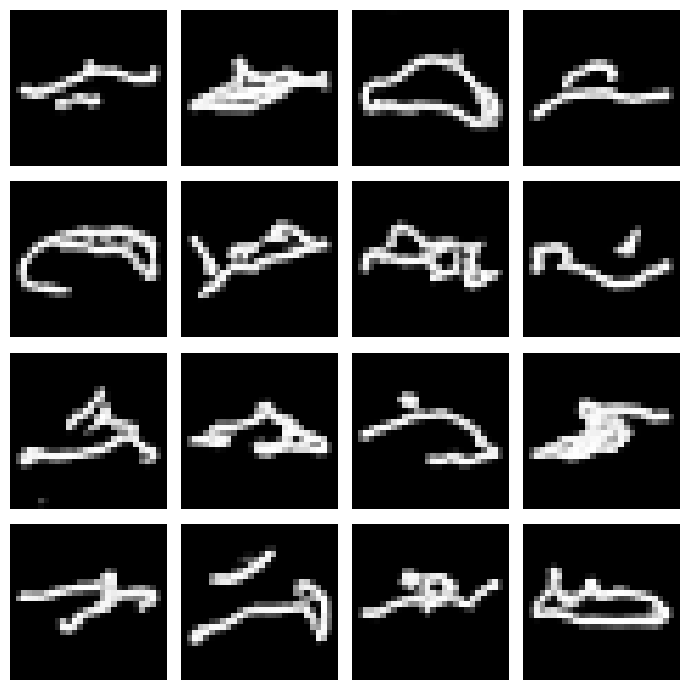

Epoch #7799
7799: [D loss: 0.1409389, acc:0.9375000] [A loss: 2.8374972, acc: 0.1250000]
1/1 [==============================] - 0s 17ms/step


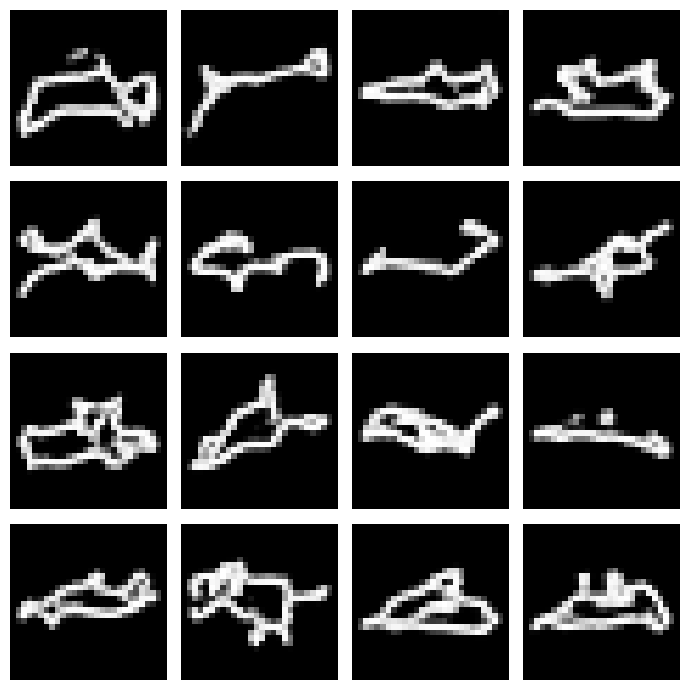

Epoch #7999
7999: [D loss: 0.1899319, acc:0.9375000] [A loss: 3.4235191, acc: 0.0625000]
1/1 [==============================] - 0s 17ms/step


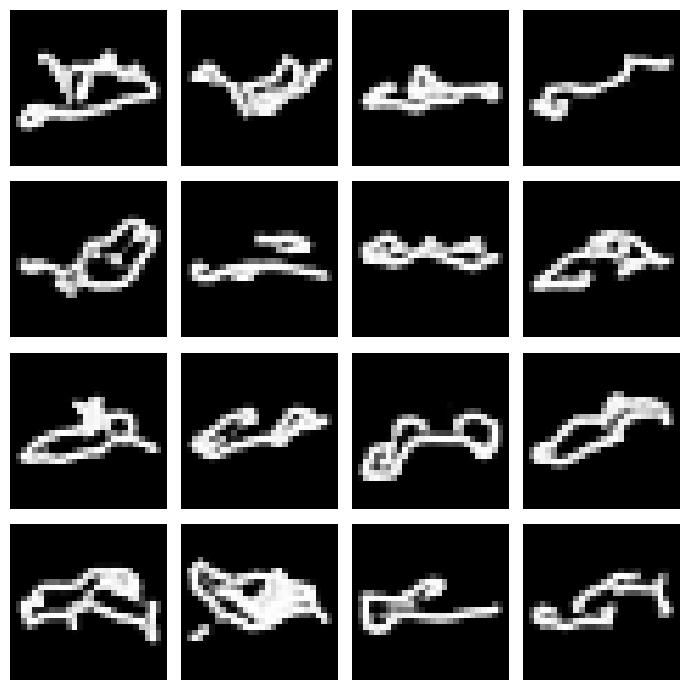

Epoch #8199
8199: [D loss: 0.1190053, acc:0.9531250] [A loss: 4.5252447, acc: 0.0000000]
1/1 [==============================] - 0s 18ms/step


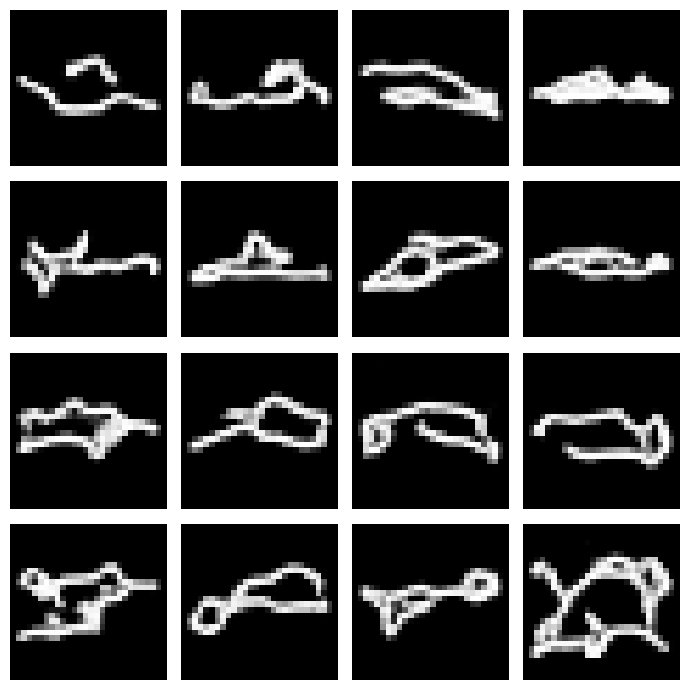

Epoch #8399
8399: [D loss: 0.2043669, acc:0.9218750] [A loss: 5.3973432, acc: 0.0156250]
1/1 [==============================] - 0s 17ms/step


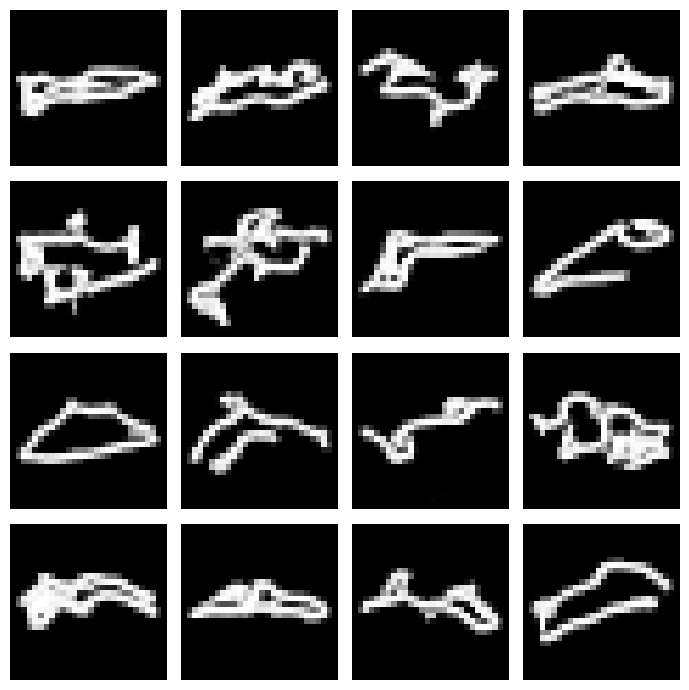

Epoch #8599
8599: [D loss: 0.1624305, acc:0.9453125] [A loss: 4.2075830, acc: 0.0312500]
1/1 [==============================] - 0s 18ms/step


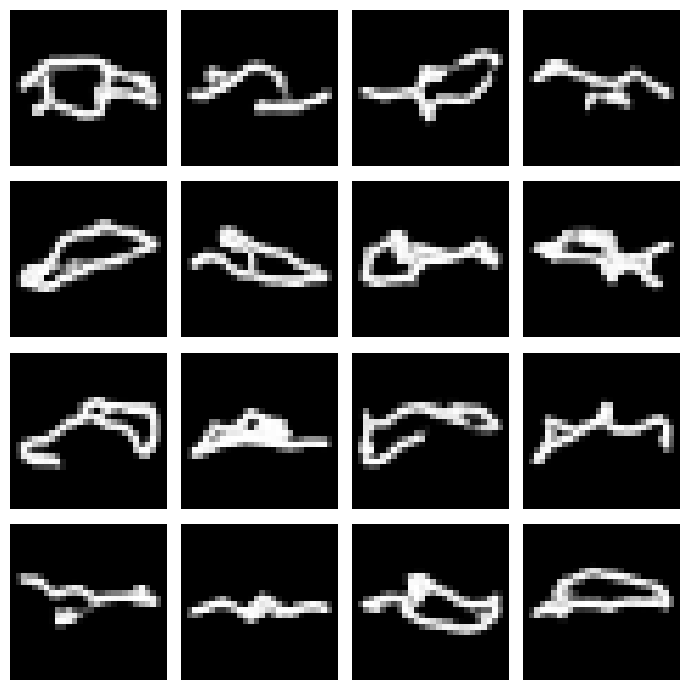

Epoch #8799
8799: [D loss: 0.2721672, acc:0.8906250] [A loss: 4.6725602, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


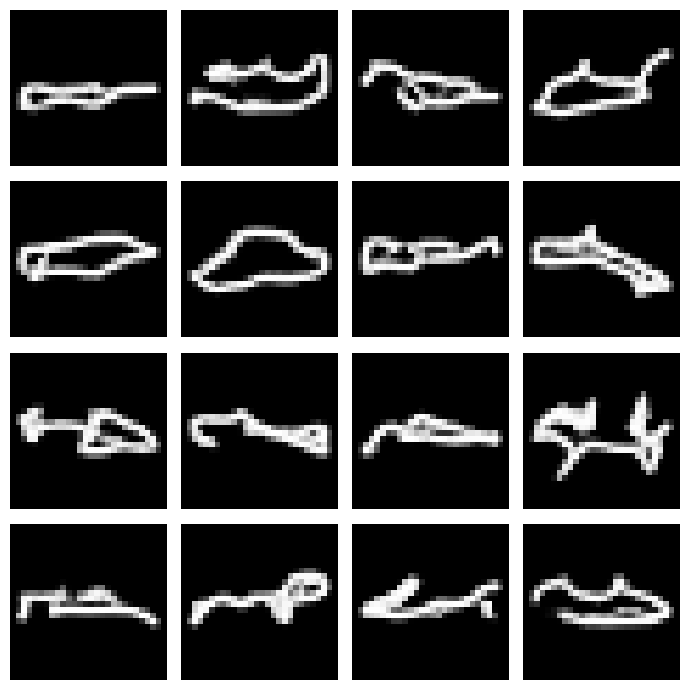

Epoch #8999
8999: [D loss: 0.1149846, acc:0.9531250] [A loss: 5.6257138, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


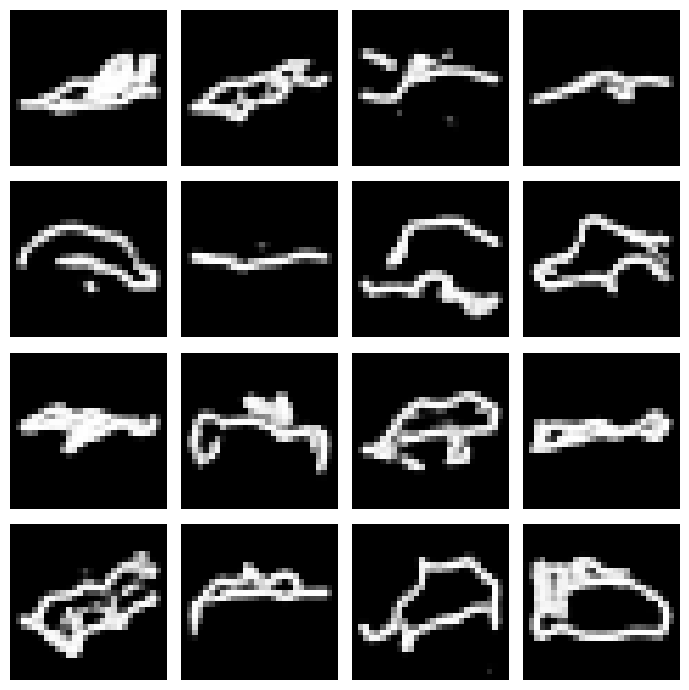

Epoch #9199
9199: [D loss: 0.2331919, acc:0.8906250] [A loss: 2.8983998, acc: 0.1250000]
1/1 [==============================] - 0s 18ms/step


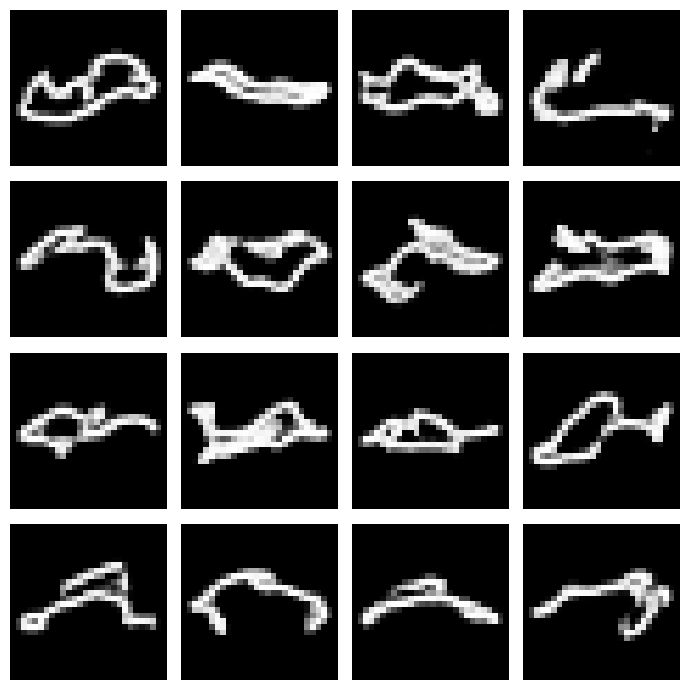

Epoch #9399
9399: [D loss: 0.2418905, acc:0.9218750] [A loss: 4.9168653, acc: 0.0156250]
1/1 [==============================] - 0s 18ms/step


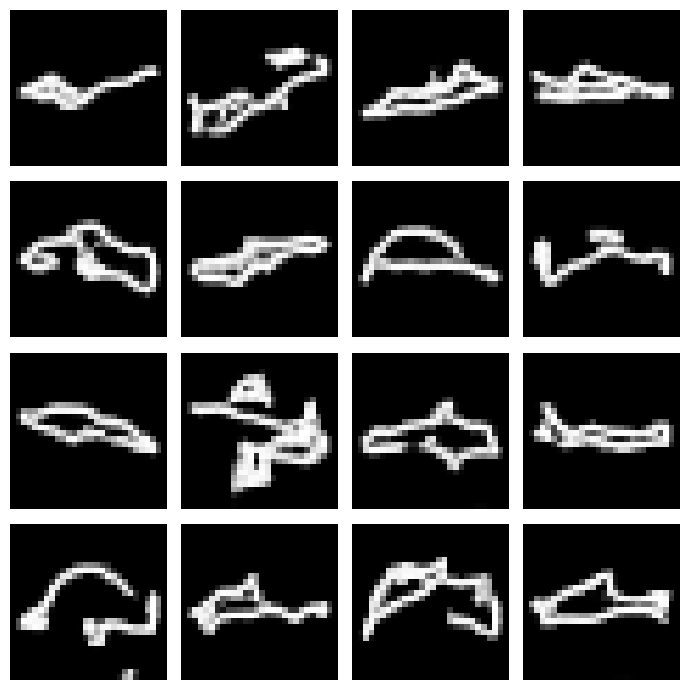

Epoch #9599
9599: [D loss: 0.2492032, acc:0.8984375] [A loss: 2.1640389, acc: 0.2343750]
1/1 [==============================] - 0s 17ms/step


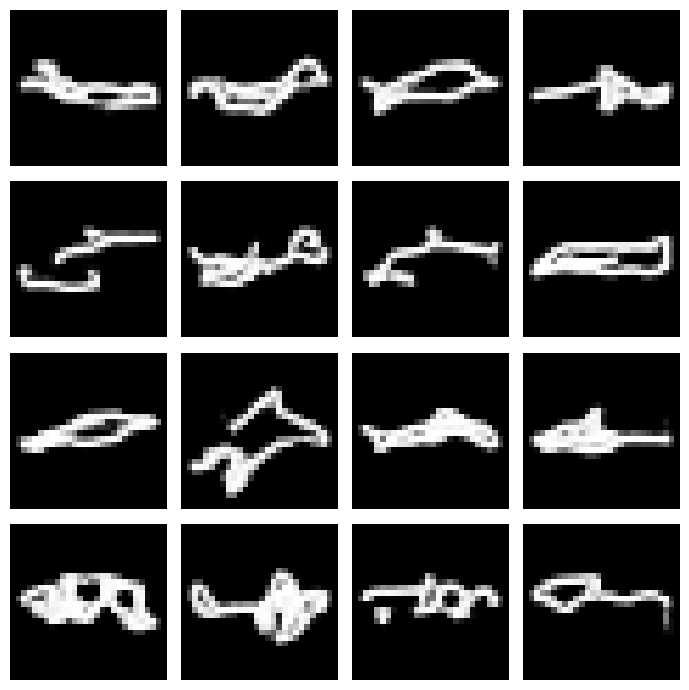

Epoch #9799
9799: [D loss: 0.1675480, acc:0.9218750] [A loss: 3.9500327, acc: 0.0312500]
1/1 [==============================] - 0s 17ms/step


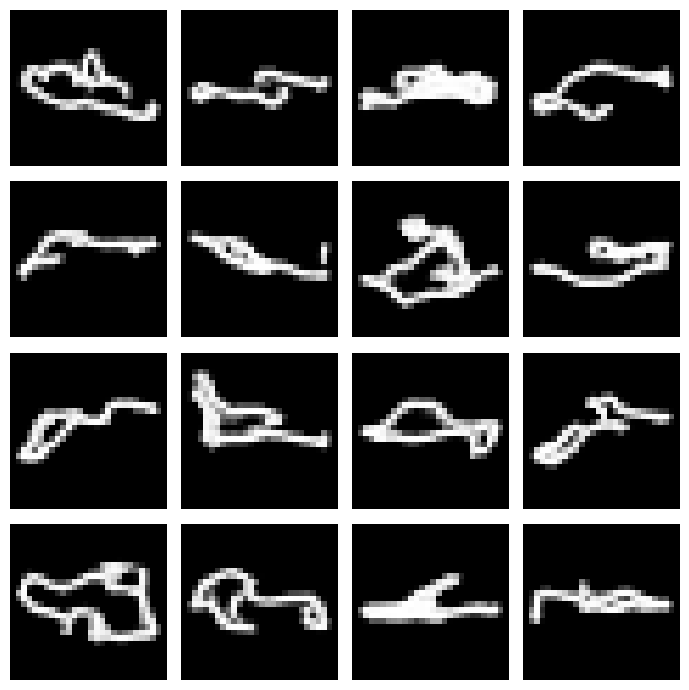

Epoch #9999
9999: [D loss: 0.1748272, acc:0.9296875] [A loss: 4.1735773, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


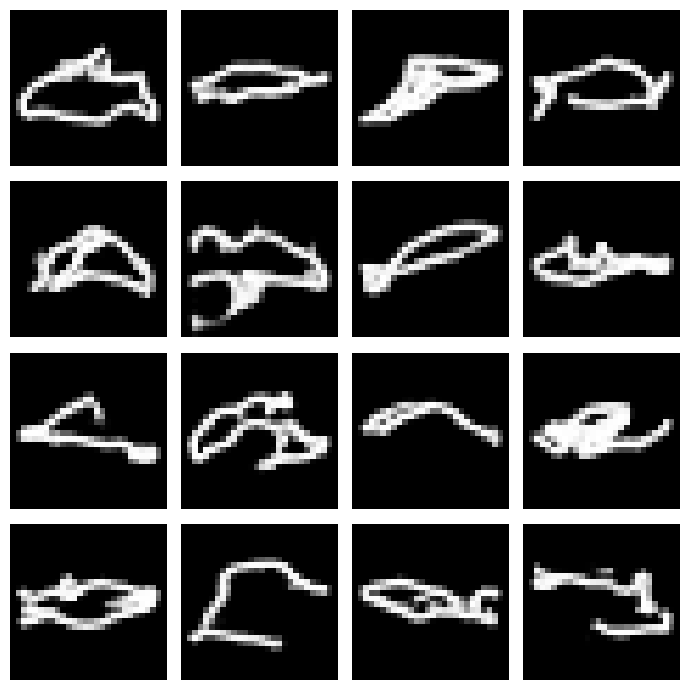

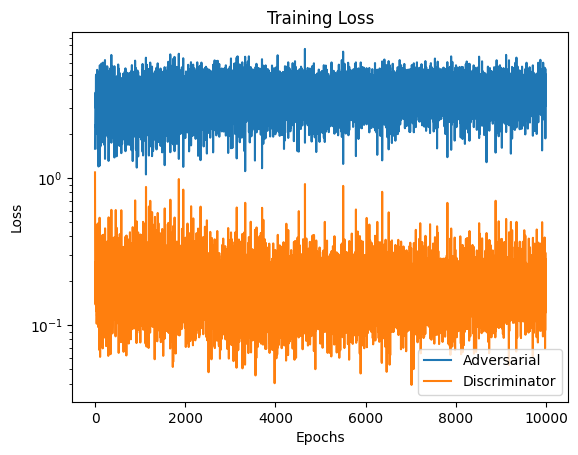

1/1 [==============================] - 0s 131ms/step


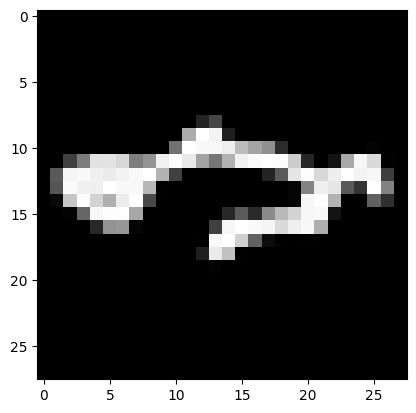

------------guitar-------------


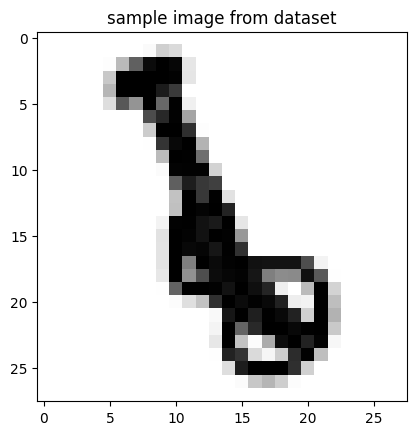

Epoch #199
199: [D loss: 0.1181319, acc:0.9765625] [A loss: 4.5405045, acc: 0.0156250]
1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_635601/428276689.py:78: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, k+1)


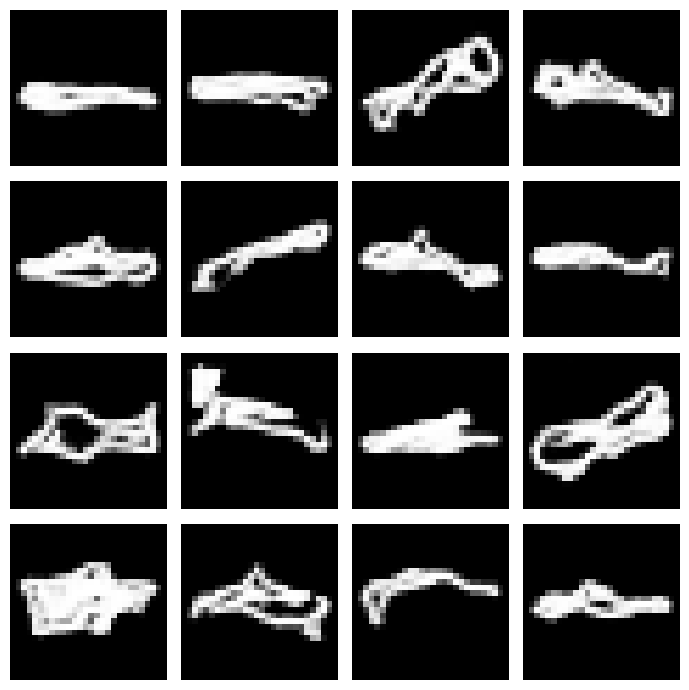

/home/estudiante/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch #399
399: [D loss: 0.1602569, acc:0.9140625] [A loss: 3.3668652, acc: 0.0625000]
1/1 [==============================] - 0s 17ms/step


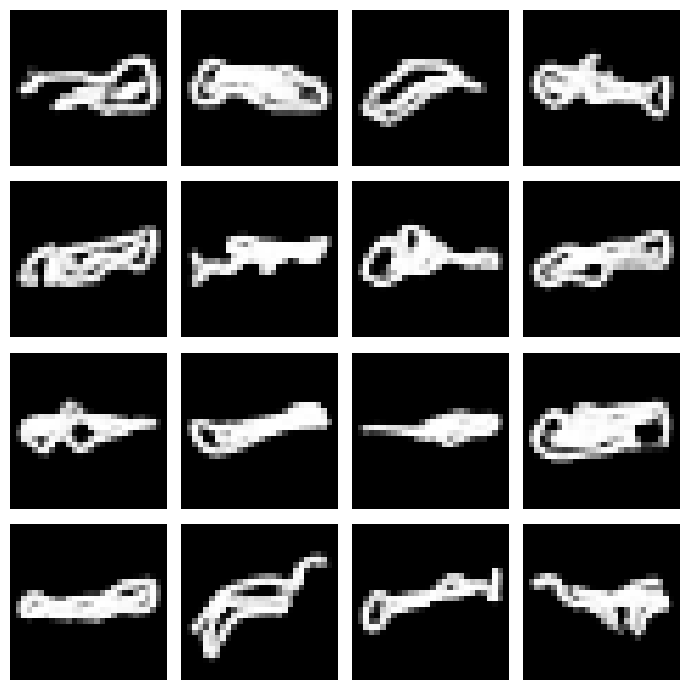

Epoch #599
599: [D loss: 0.1340168, acc:0.9531250] [A loss: 3.3073382, acc: 0.0468750]
1/1 [==============================] - 0s 17ms/step


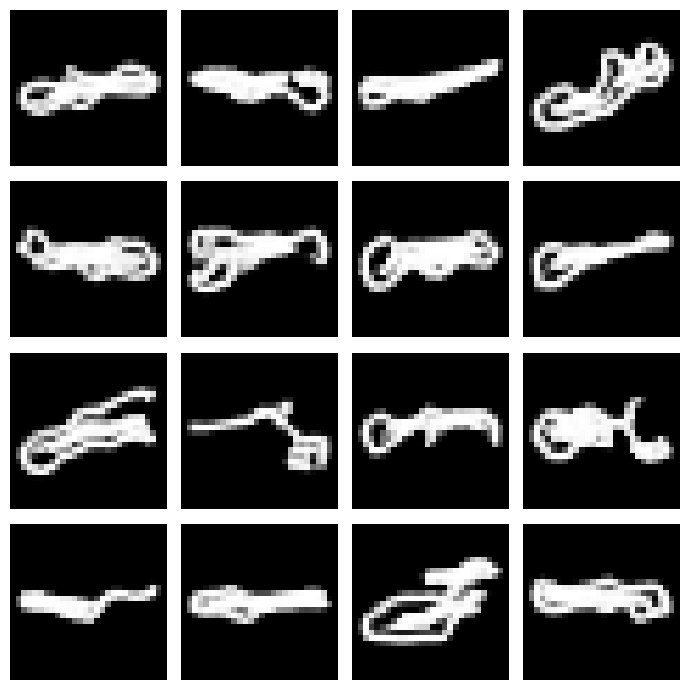

Epoch #799
799: [D loss: 0.1639722, acc:0.9296875] [A loss: 3.9563107, acc: 0.0156250]
1/1 [==============================] - 0s 18ms/step


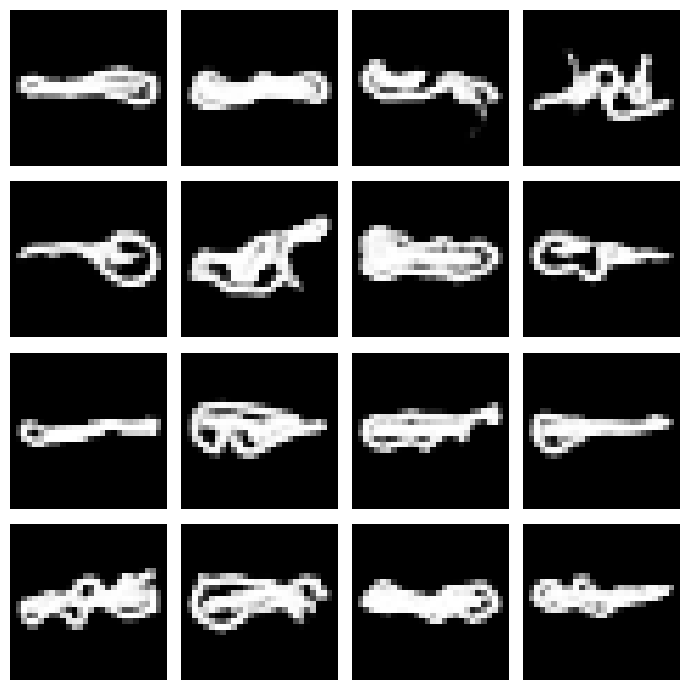

Epoch #999
999: [D loss: 0.2148056, acc:0.8984375] [A loss: 3.4829750, acc: 0.0625000]
1/1 [==============================] - 0s 17ms/step


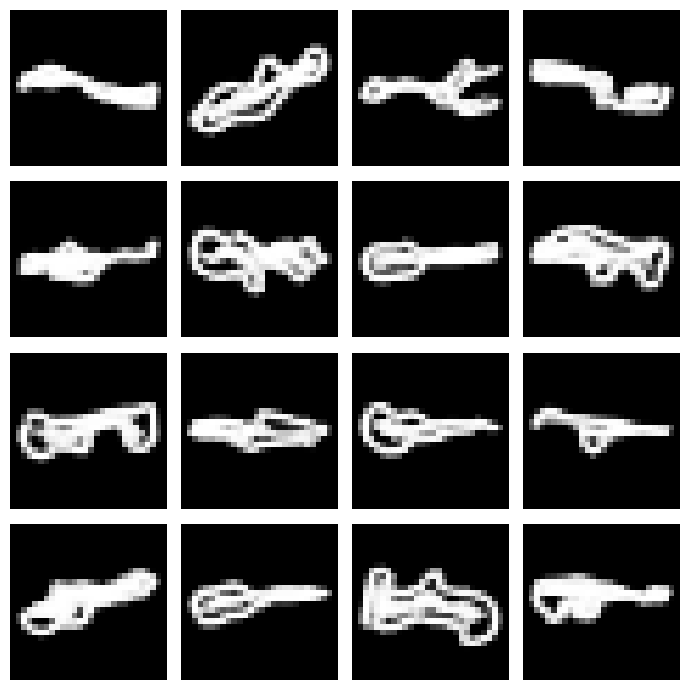

Epoch #1199
1199: [D loss: 0.1863917, acc:0.9218750] [A loss: 3.9493427, acc: 0.0000000]
1/1 [==============================] - 0s 18ms/step


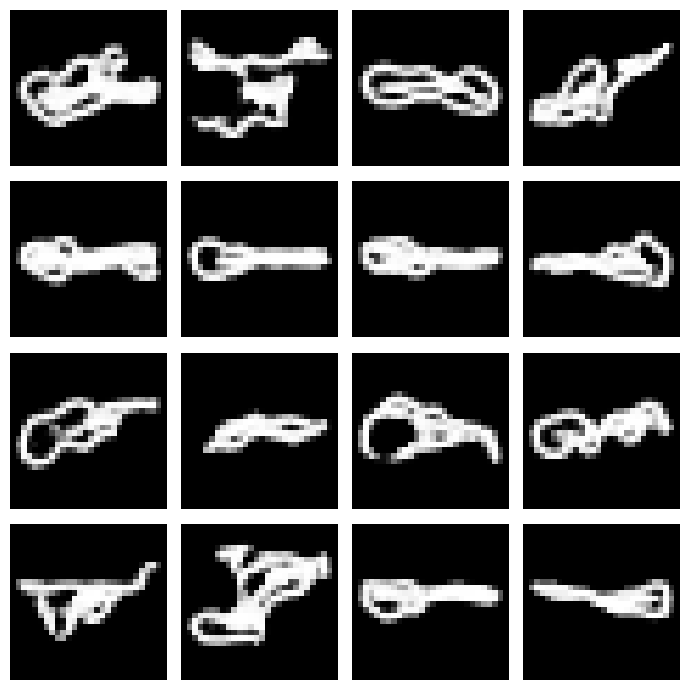

Epoch #1399
1399: [D loss: 0.1622487, acc:0.9296875] [A loss: 3.4794040, acc: 0.0312500]
1/1 [==============================] - 0s 18ms/step


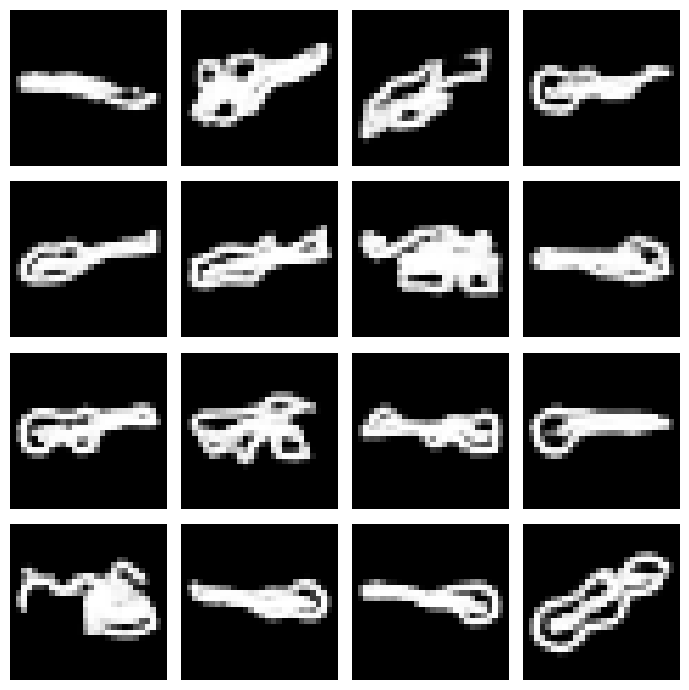

Epoch #1599
1599: [D loss: 0.1908199, acc:0.9218750] [A loss: 3.2481756, acc: 0.0468750]
1/1 [==============================] - 0s 18ms/step


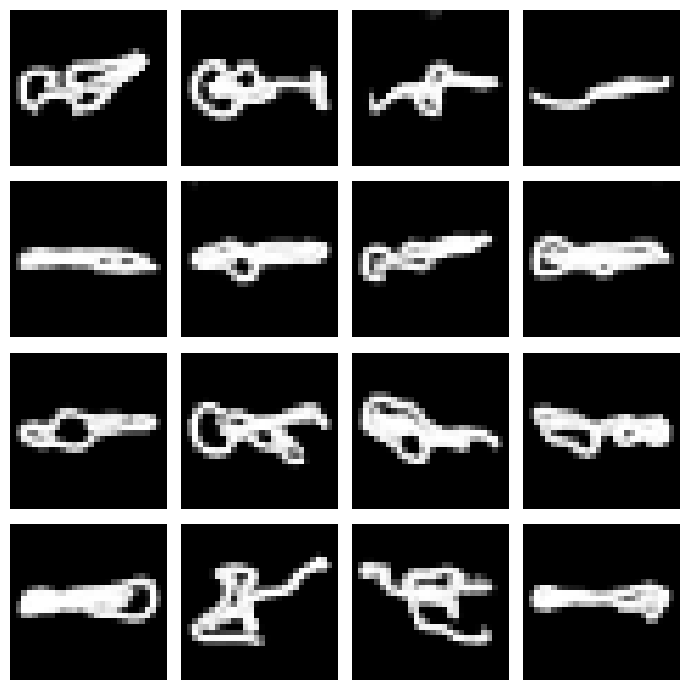

Epoch #1799
1799: [D loss: 0.2386549, acc:0.8984375] [A loss: 2.9744349, acc: 0.0625000]
1/1 [==============================] - 0s 18ms/step


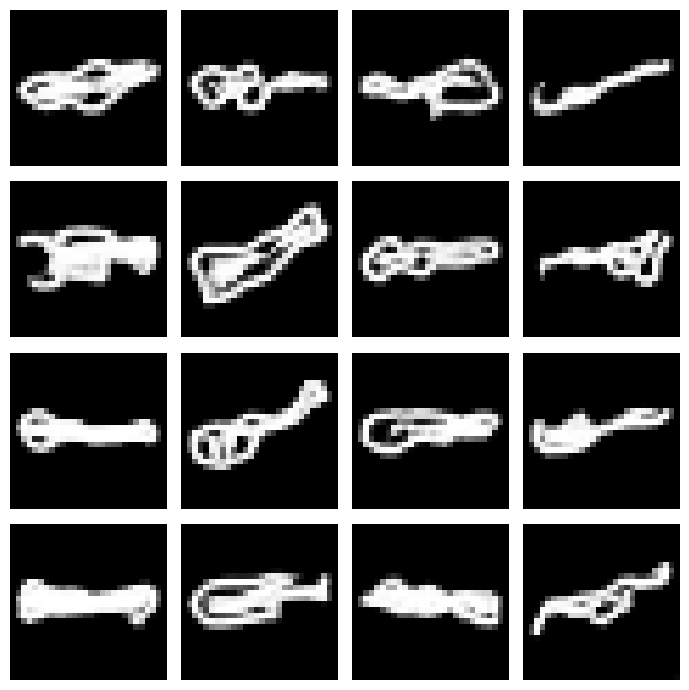

Epoch #1999
1999: [D loss: 0.1301674, acc:0.9453125] [A loss: 3.7785325, acc: 0.0156250]
1/1 [==============================] - 0s 20ms/step


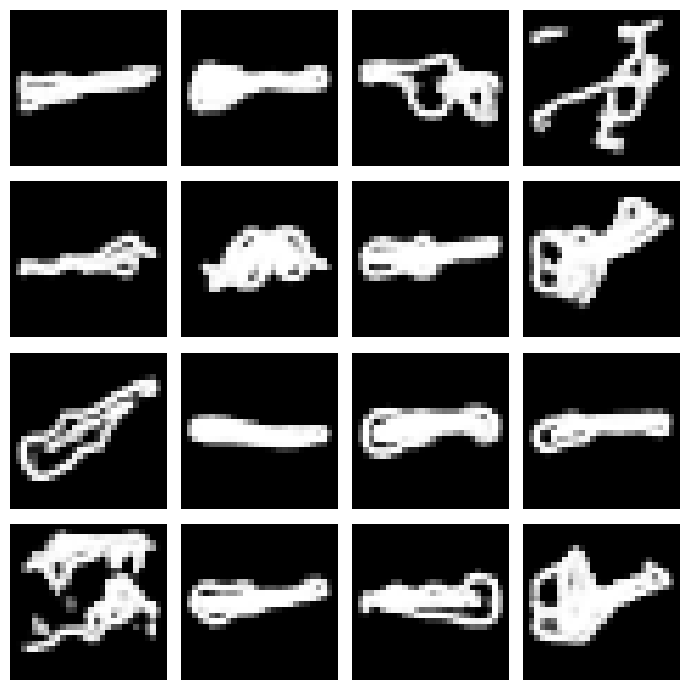

Epoch #2199
2199: [D loss: 0.1997377, acc:0.9140625] [A loss: 2.4080825, acc: 0.1406250]
1/1 [==============================] - 0s 18ms/step


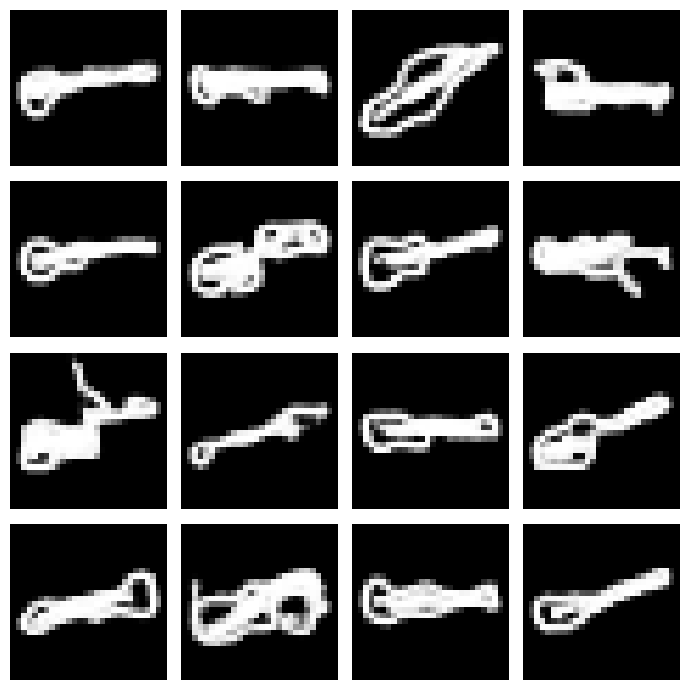

Epoch #2399
2399: [D loss: 0.1445745, acc:0.9609375] [A loss: 3.7388923, acc: 0.0156250]
1/1 [==============================] - 0s 20ms/step


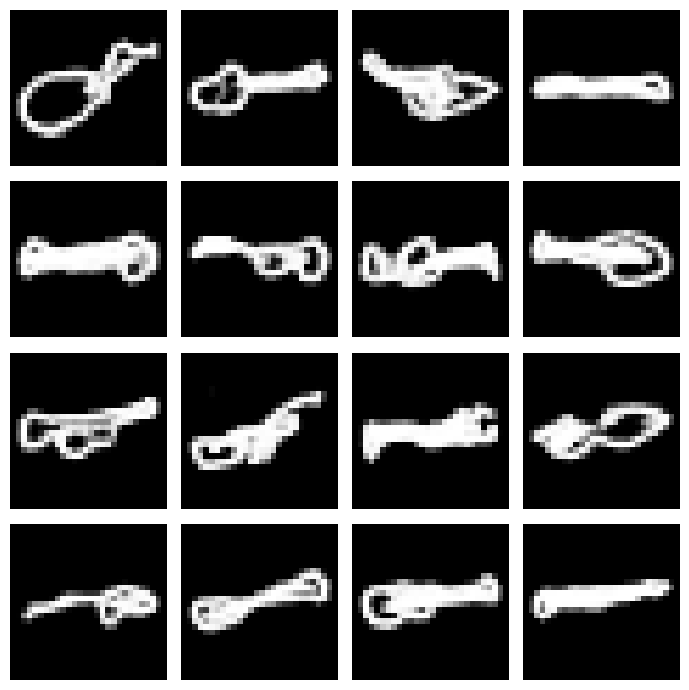

Epoch #2599
2599: [D loss: 0.3106411, acc:0.8593750] [A loss: 2.5366764, acc: 0.1093750]
1/1 [==============================] - 0s 17ms/step


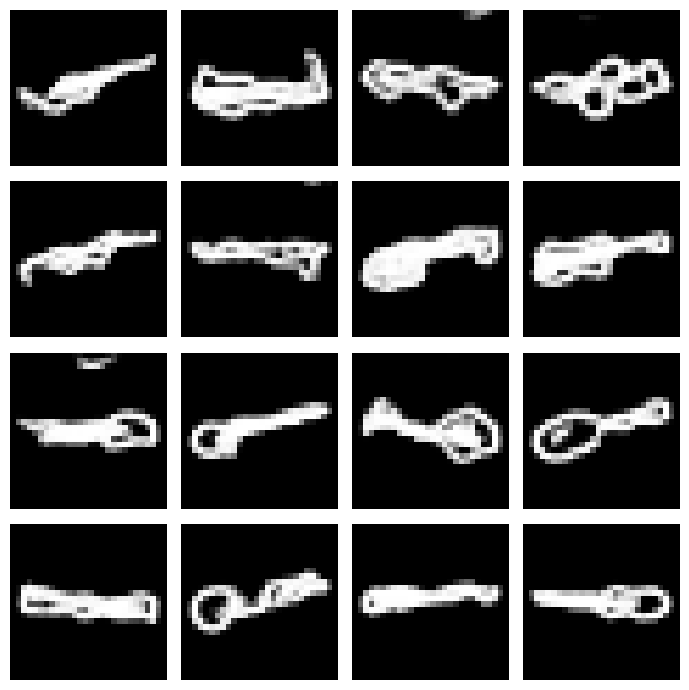

Epoch #2799
2799: [D loss: 0.2565309, acc:0.8984375] [A loss: 2.1991410, acc: 0.1250000]
1/1 [==============================] - 0s 19ms/step


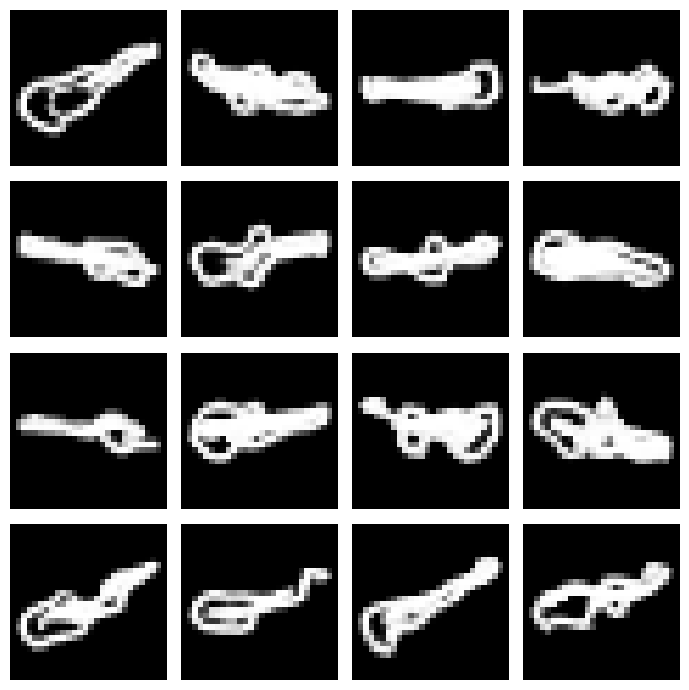

Epoch #2999
2999: [D loss: 0.2095532, acc:0.9062500] [A loss: 2.5442739, acc: 0.0625000]
1/1 [==============================] - 0s 17ms/step


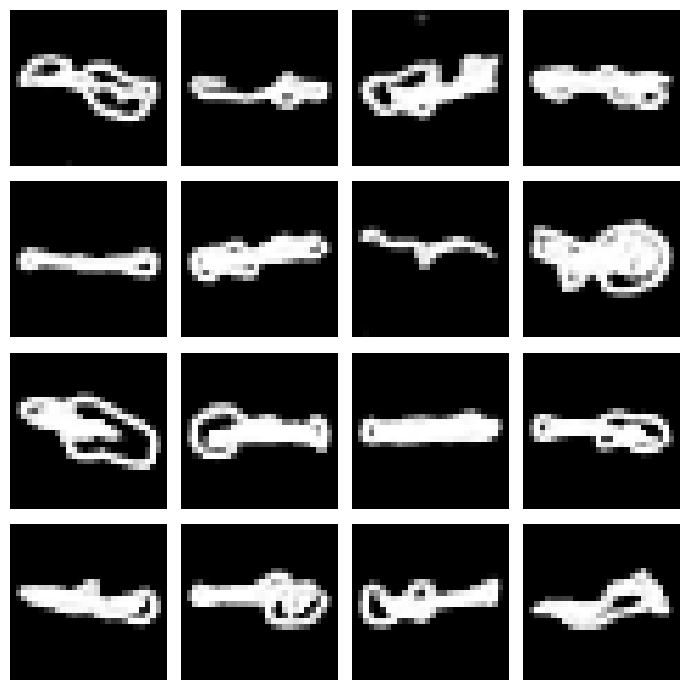

Epoch #3199
3199: [D loss: 0.2833699, acc:0.8593750] [A loss: 2.9079828, acc: 0.0156250]
1/1 [==============================] - 0s 19ms/step


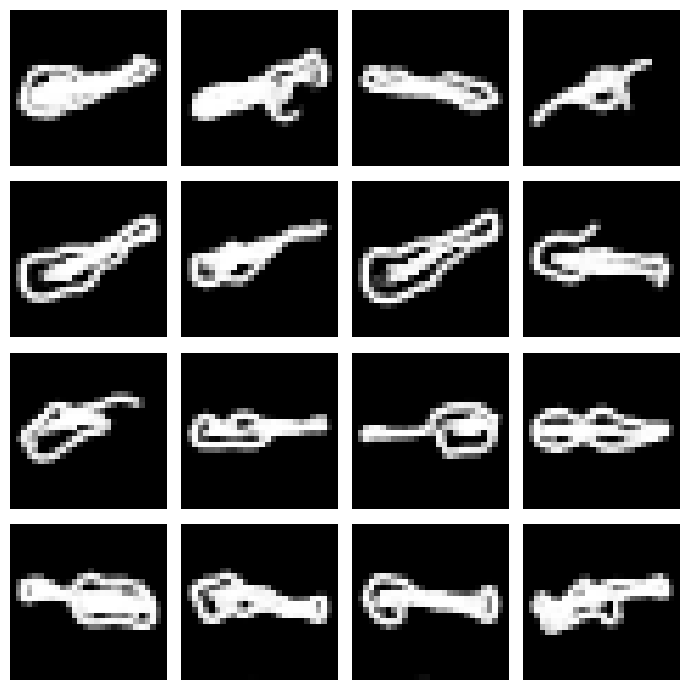

Epoch #3399
3399: [D loss: 0.2679218, acc:0.9062500] [A loss: 2.7474470, acc: 0.0156250]
1/1 [==============================] - 0s 17ms/step


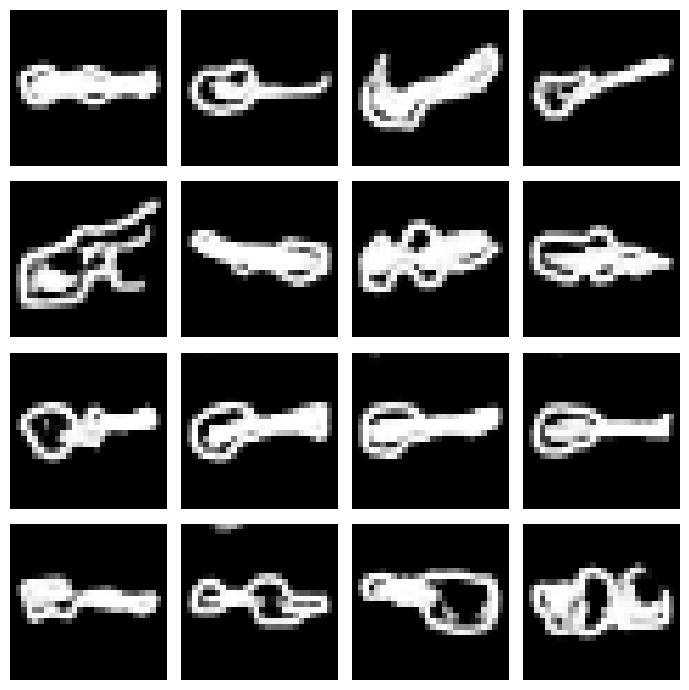

Epoch #3599
3599: [D loss: 0.1586055, acc:0.9218750] [A loss: 2.7673321, acc: 0.0625000]
1/1 [==============================] - 0s 19ms/step


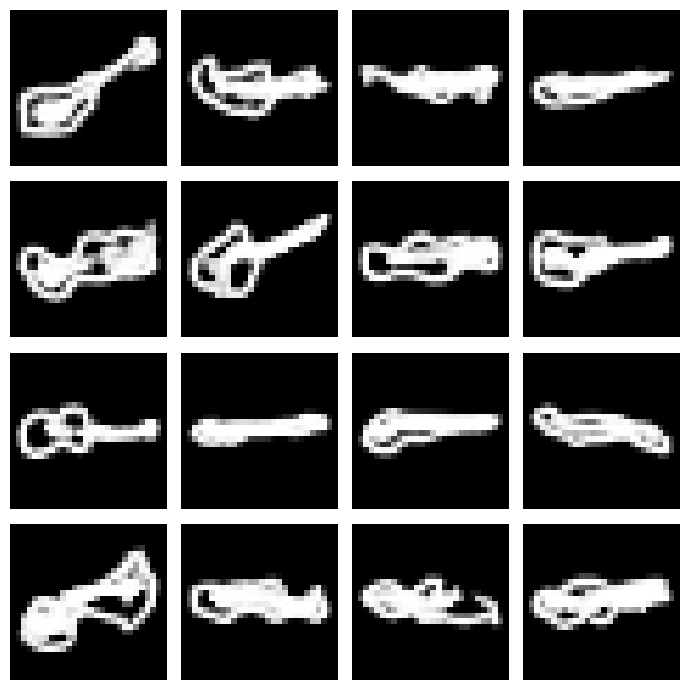

Epoch #3799
3799: [D loss: 0.1750413, acc:0.9218750] [A loss: 3.0649314, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


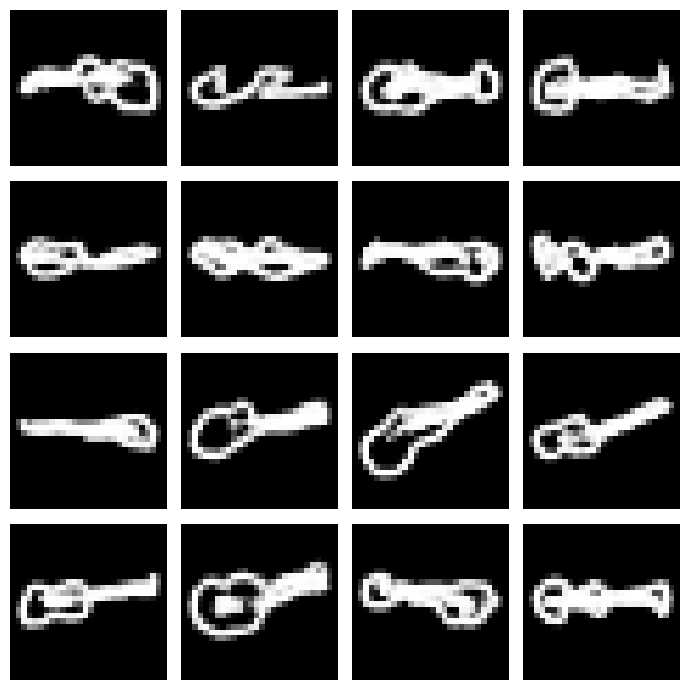

Epoch #3999
3999: [D loss: 0.1925517, acc:0.8984375] [A loss: 3.2290864, acc: 0.0625000]
1/1 [==============================] - 0s 17ms/step


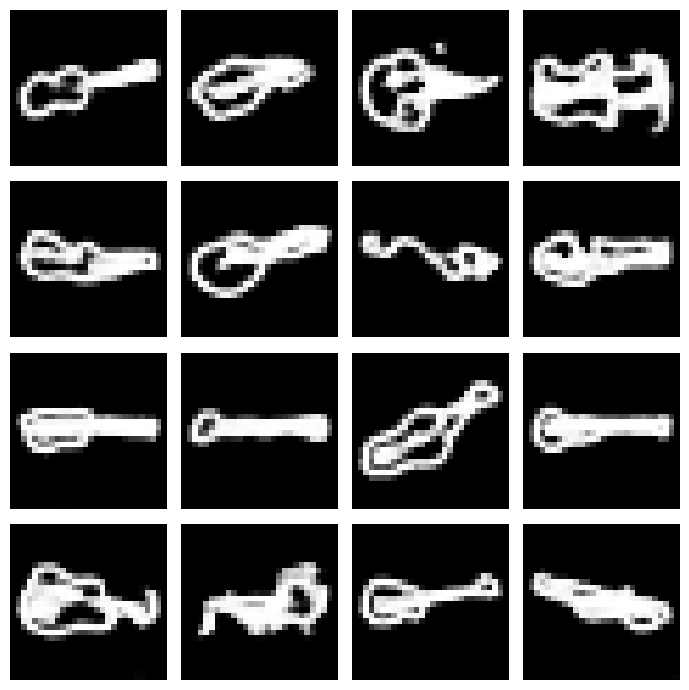

Epoch #4199
4199: [D loss: 0.2314258, acc:0.9296875] [A loss: 2.6236408, acc: 0.0468750]
1/1 [==============================] - 0s 18ms/step


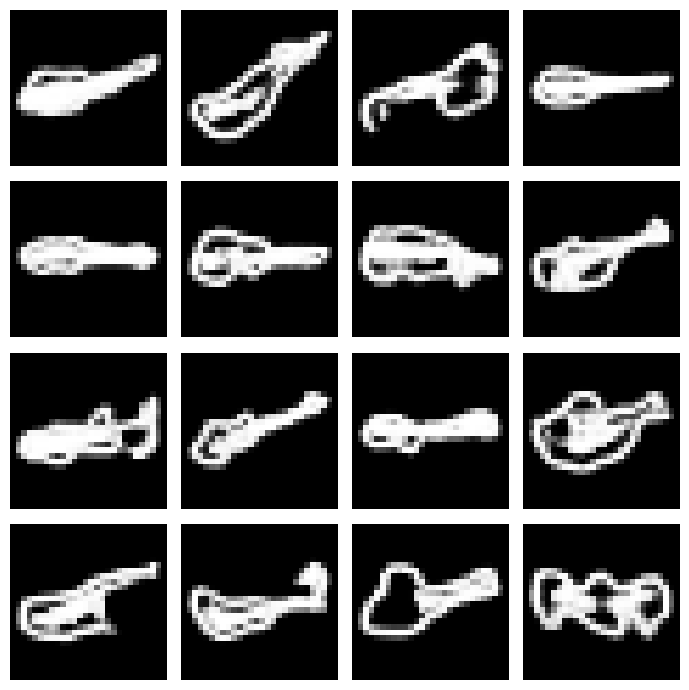

Epoch #4399
4399: [D loss: 0.2157194, acc:0.8906250] [A loss: 3.8037229, acc: 0.0156250]
1/1 [==============================] - 0s 17ms/step


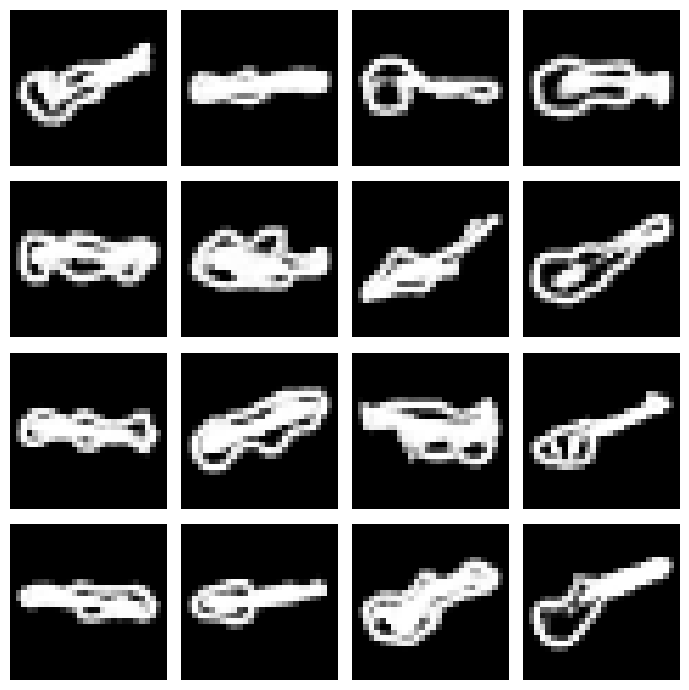

Epoch #4599
4599: [D loss: 0.2073853, acc:0.9140625] [A loss: 3.3285418, acc: 0.0312500]
1/1 [==============================] - 0s 18ms/step


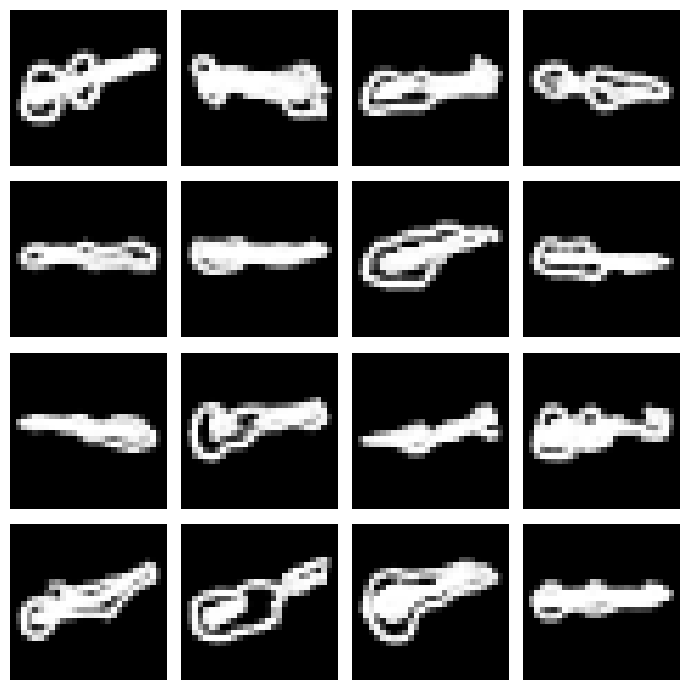

Epoch #4799
4799: [D loss: 0.1815435, acc:0.9296875] [A loss: 2.6135516, acc: 0.0312500]
1/1 [==============================] - 0s 17ms/step


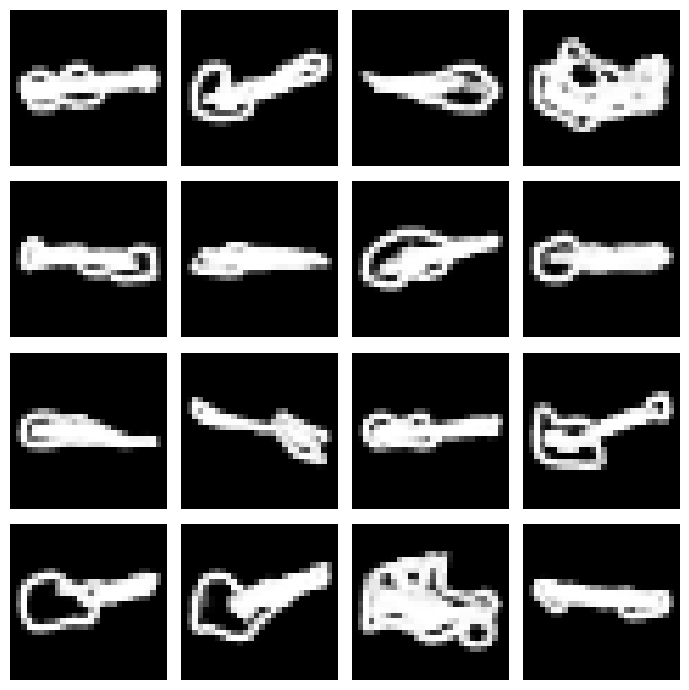

Epoch #4999
4999: [D loss: 0.2149194, acc:0.8906250] [A loss: 3.5725965, acc: 0.0156250]
1/1 [==============================] - 0s 18ms/step


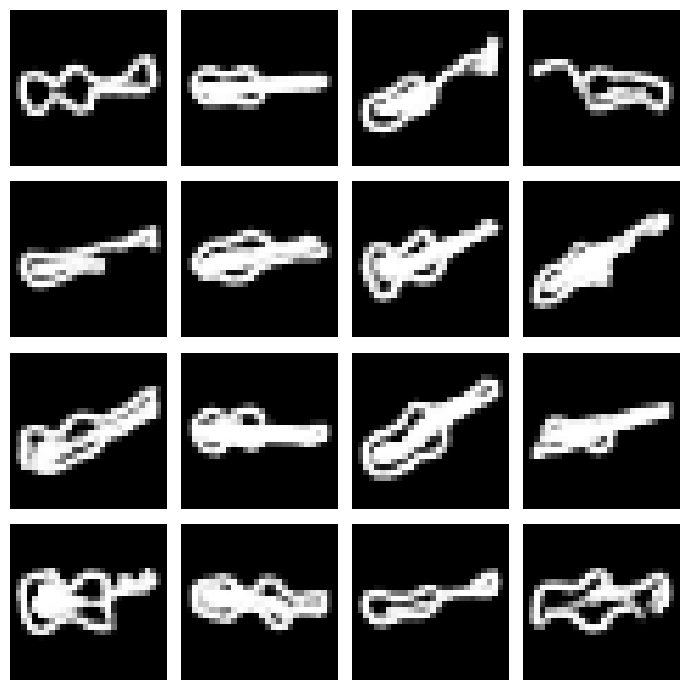

Epoch #5199
5199: [D loss: 0.1558865, acc:0.9296875] [A loss: 2.7954097, acc: 0.0625000]
1/1 [==============================] - 0s 17ms/step


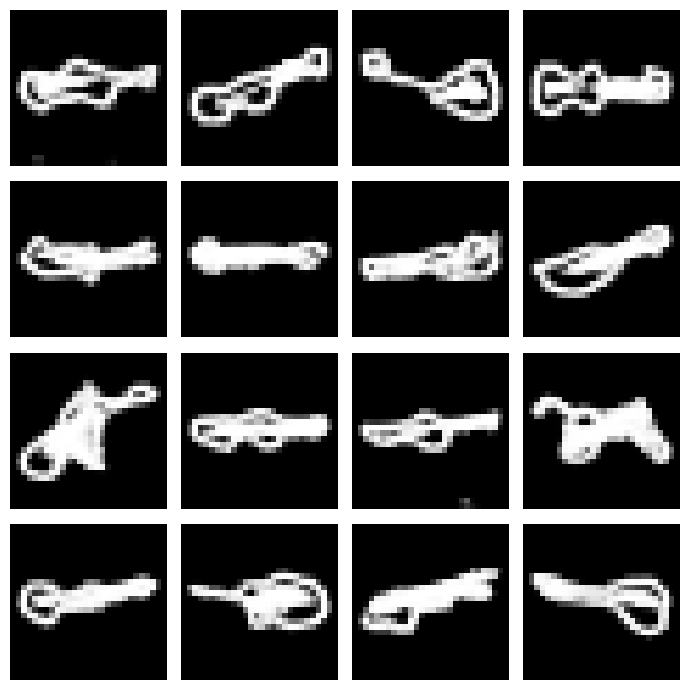

Epoch #5399
5399: [D loss: 0.1607892, acc:0.9453125] [A loss: 2.7240105, acc: 0.0312500]
1/1 [==============================] - 0s 18ms/step


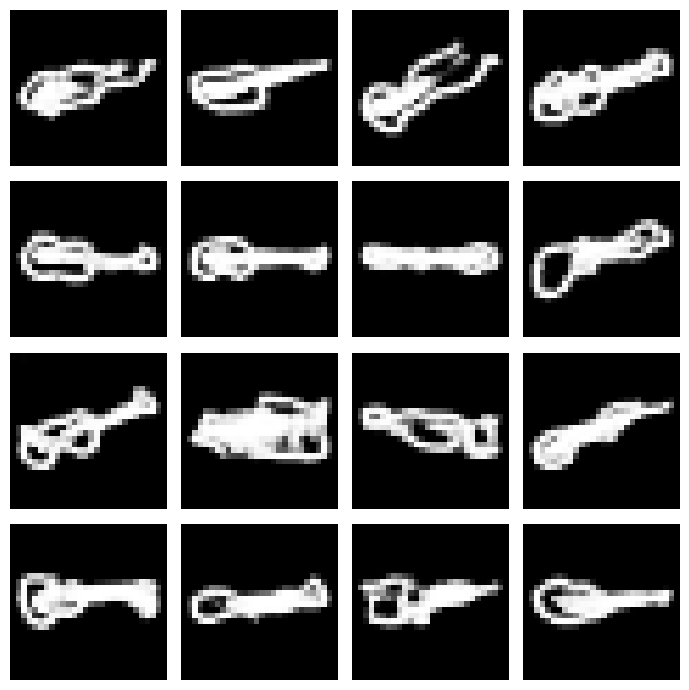

Epoch #5599
5599: [D loss: 0.1611756, acc:0.9375000] [A loss: 3.3186433, acc: 0.0468750]
1/1 [==============================] - 0s 17ms/step


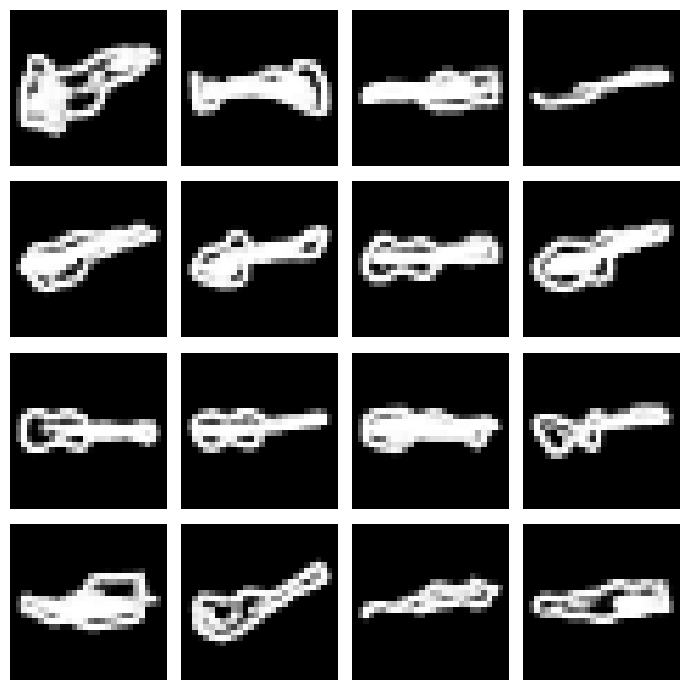

Epoch #5799
5799: [D loss: 0.3073871, acc:0.8671875] [A loss: 3.0010090, acc: 0.0312500]
1/1 [==============================] - 0s 19ms/step


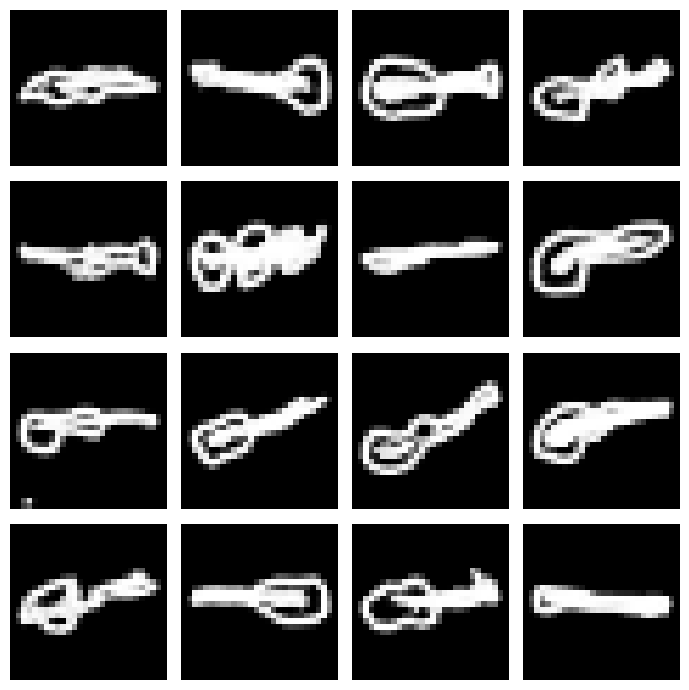

Epoch #5999
5999: [D loss: 0.2139985, acc:0.9062500] [A loss: 2.6268830, acc: 0.0156250]
1/1 [==============================] - 0s 17ms/step


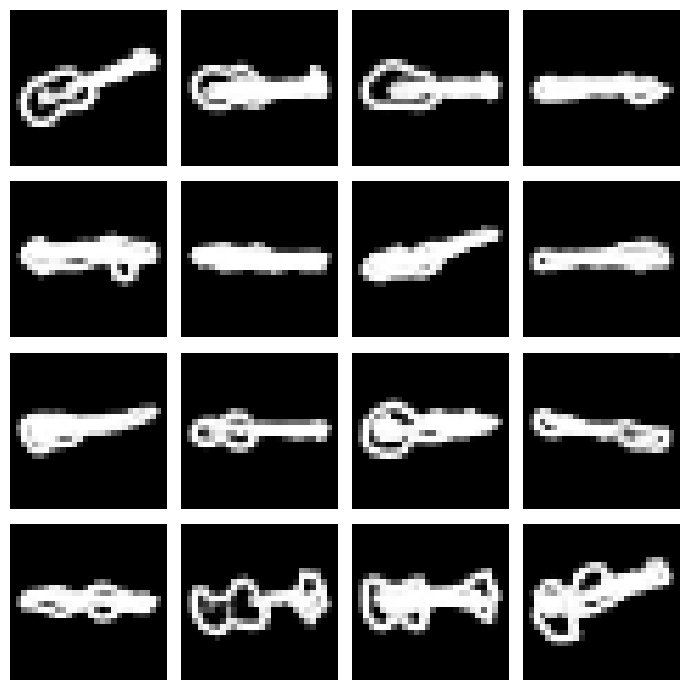

Epoch #6199
6199: [D loss: 0.1553716, acc:0.9375000] [A loss: 2.9285450, acc: 0.0468750]
1/1 [==============================] - 0s 19ms/step


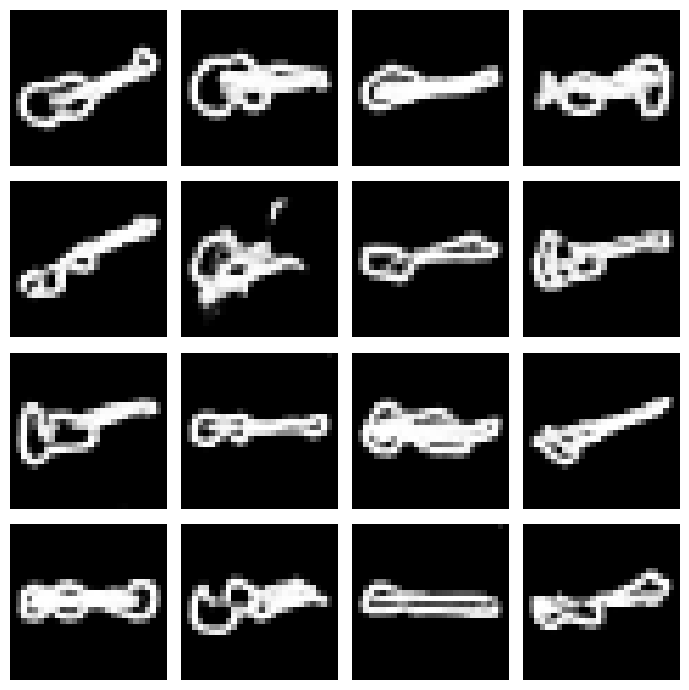

Epoch #6399
6399: [D loss: 0.2655497, acc:0.8906250] [A loss: 2.2909374, acc: 0.0625000]
1/1 [==============================] - 0s 17ms/step


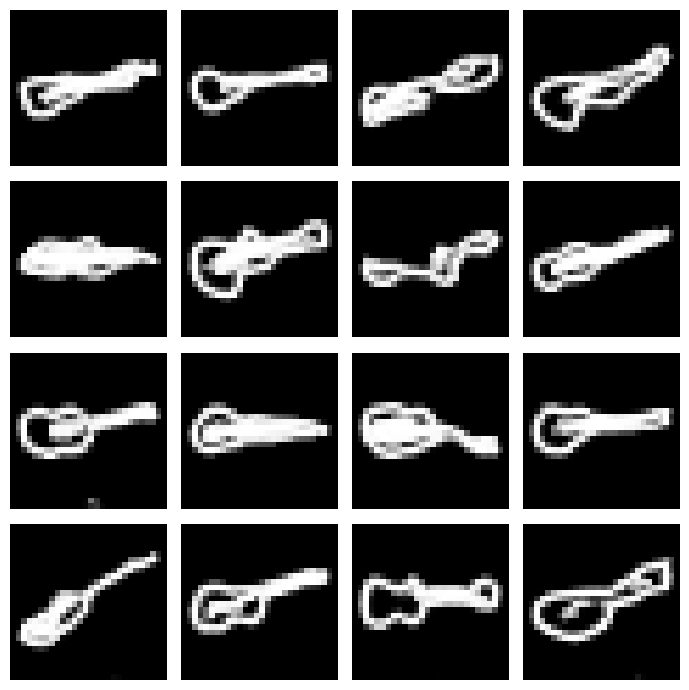

Epoch #6599
6599: [D loss: 0.1579753, acc:0.9453125] [A loss: 2.5162051, acc: 0.0937500]
1/1 [==============================] - 0s 20ms/step


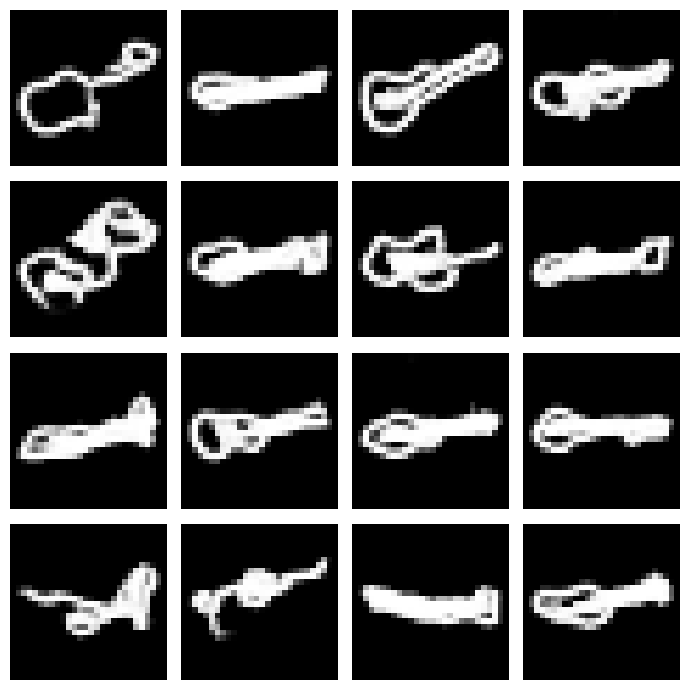

Epoch #6799
6799: [D loss: 0.2066576, acc:0.9296875] [A loss: 3.1074586, acc: 0.0625000]
1/1 [==============================] - 0s 17ms/step


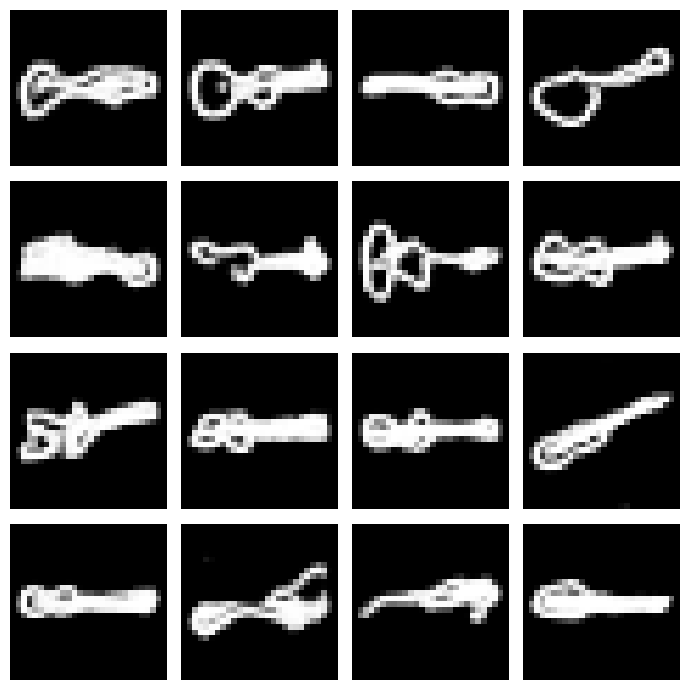

Epoch #6999
6999: [D loss: 0.1964498, acc:0.9140625] [A loss: 3.1831510, acc: 0.0781250]
1/1 [==============================] - 0s 17ms/step


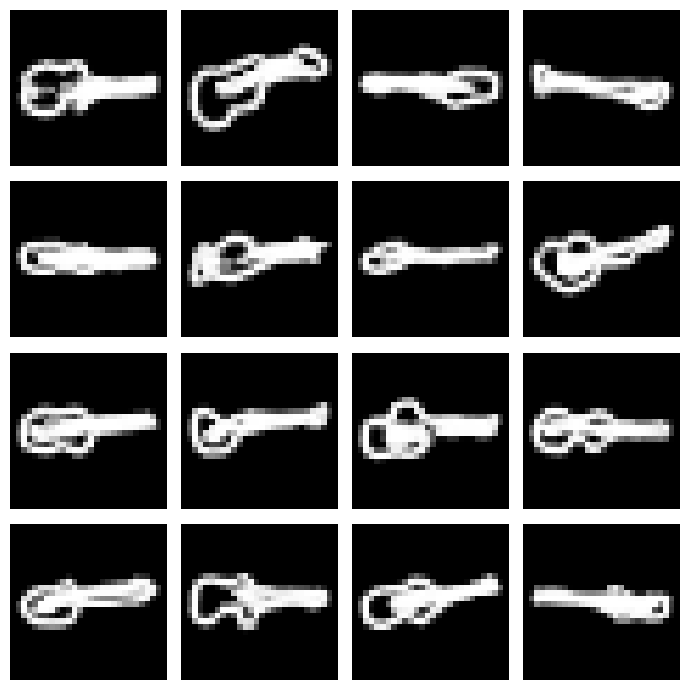

Epoch #7199
7199: [D loss: 0.2949747, acc:0.8828125] [A loss: 2.2383072, acc: 0.0625000]
1/1 [==============================] - 0s 18ms/step


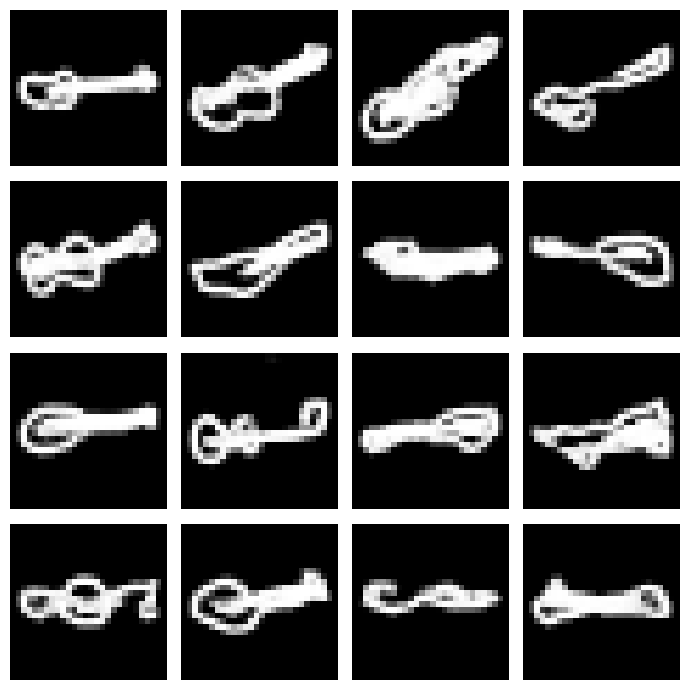

Epoch #7399
7399: [D loss: 0.1886040, acc:0.9296875] [A loss: 2.8216016, acc: 0.0312500]
1/1 [==============================] - 0s 18ms/step


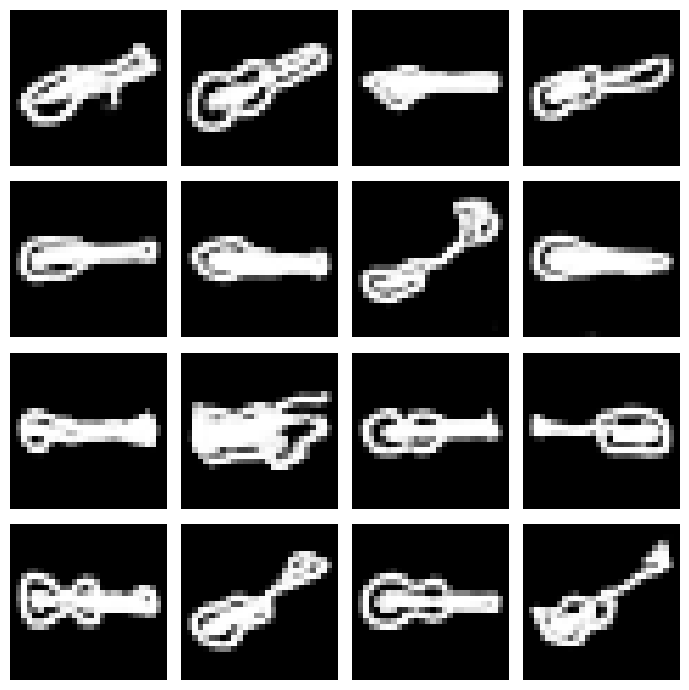

Epoch #7599
7599: [D loss: 0.1286691, acc:0.9453125] [A loss: 3.8059056, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


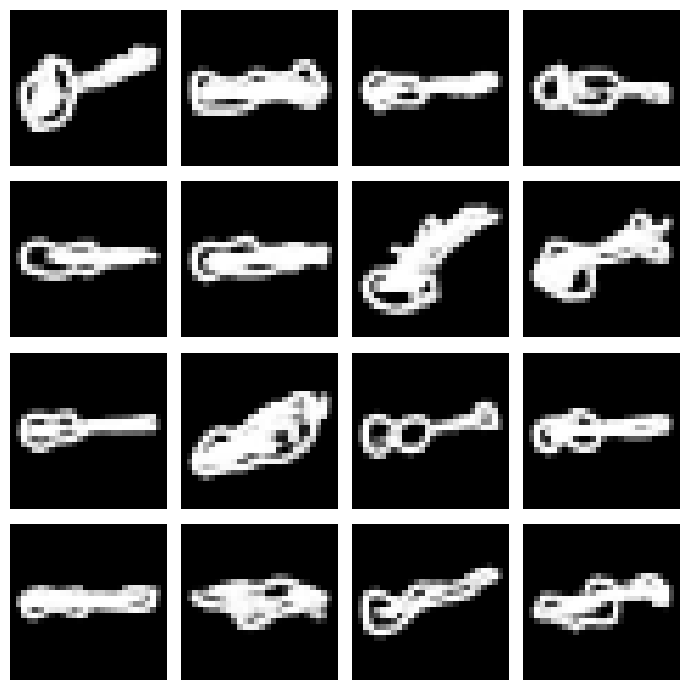

Epoch #7799
7799: [D loss: 0.1993334, acc:0.9140625] [A loss: 3.2518530, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


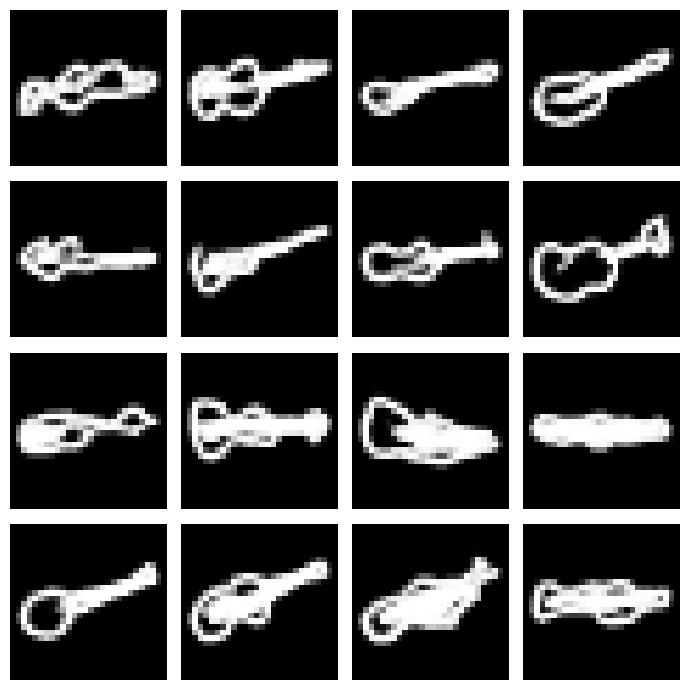

Epoch #7999
7999: [D loss: 0.2427088, acc:0.8906250] [A loss: 2.2403405, acc: 0.0625000]
1/1 [==============================] - 0s 18ms/step


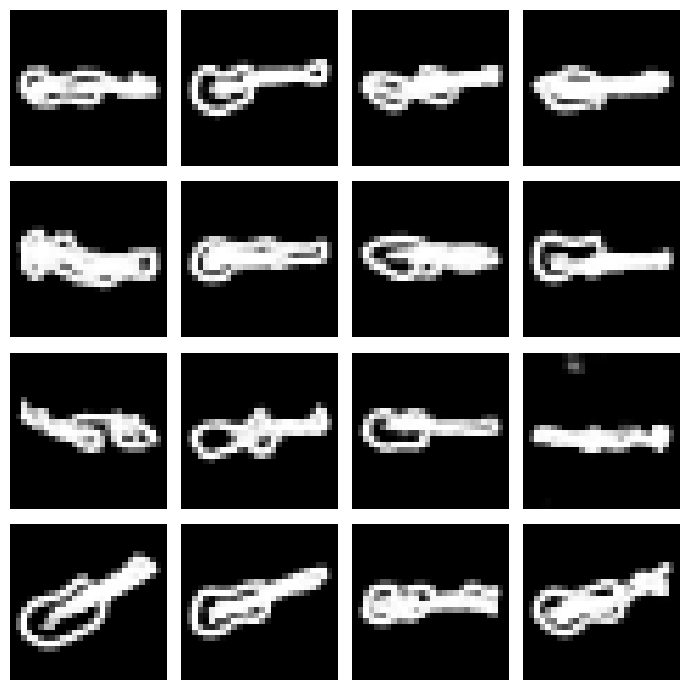

Epoch #8199
8199: [D loss: 0.1910746, acc:0.9140625] [A loss: 2.4163594, acc: 0.1093750]
1/1 [==============================] - 0s 17ms/step


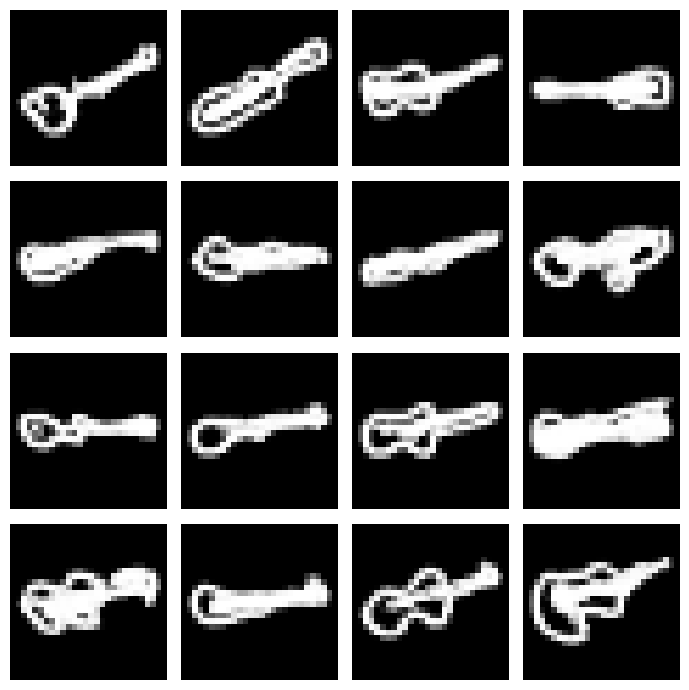

Epoch #8399
8399: [D loss: 0.2324187, acc:0.9140625] [A loss: 3.4412689, acc: 0.0312500]
1/1 [==============================] - 0s 18ms/step


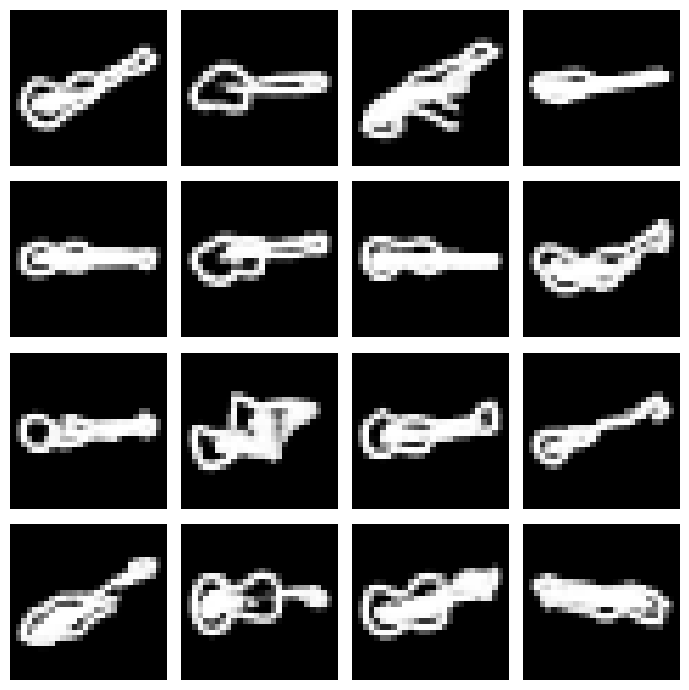

Epoch #8599
8599: [D loss: 0.1193254, acc:0.9687500] [A loss: 3.5916598, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


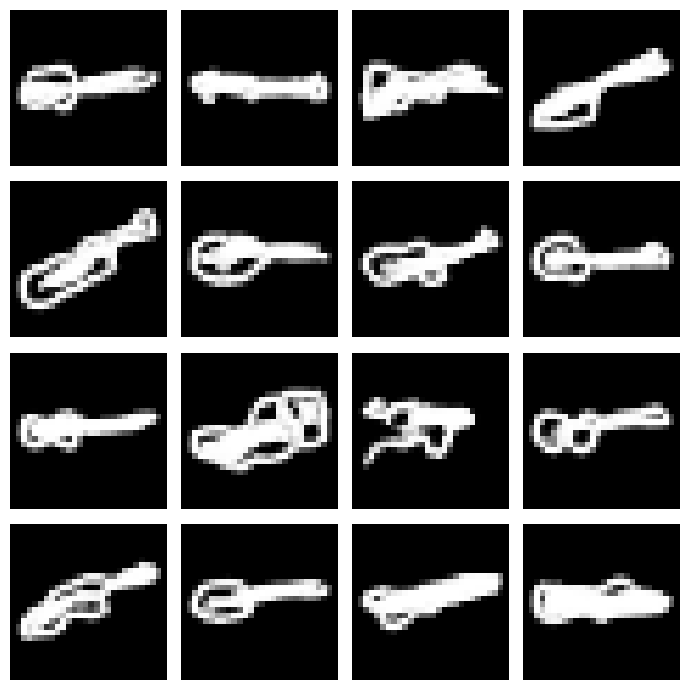

Epoch #8799
8799: [D loss: 0.2730193, acc:0.8750000] [A loss: 2.6469007, acc: 0.0000000]
1/1 [==============================] - 0s 18ms/step


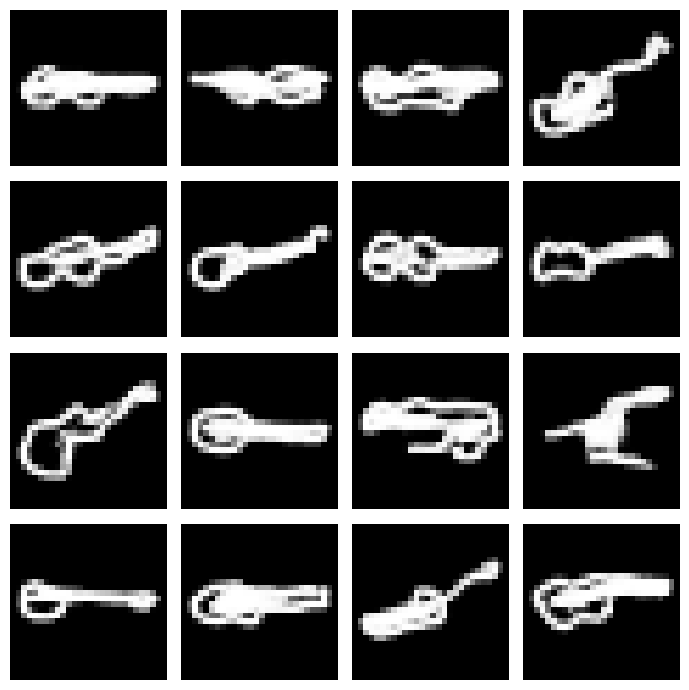

Epoch #8999
8999: [D loss: 0.2343579, acc:0.8984375] [A loss: 4.4488773, acc: 0.0000000]
1/1 [==============================] - 0s 17ms/step


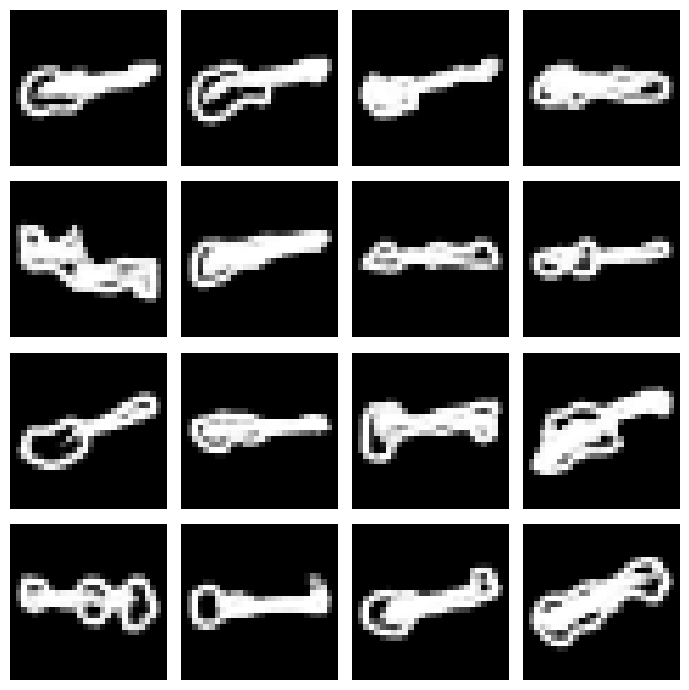

Epoch #9199
9199: [D loss: 0.1846337, acc:0.9296875] [A loss: 2.8867507, acc: 0.0312500]
1/1 [==============================] - 0s 19ms/step


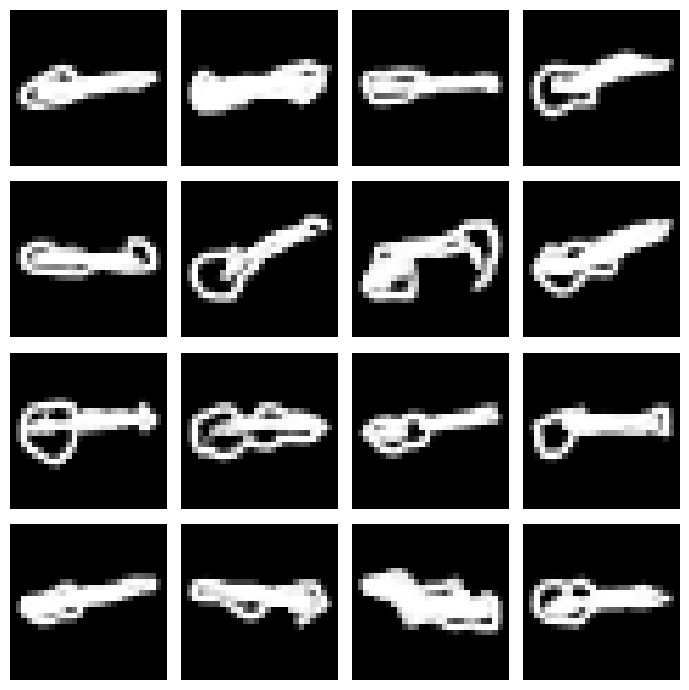

Epoch #9399
9399: [D loss: 0.2234223, acc:0.9140625] [A loss: 2.5695910, acc: 0.0625000]
1/1 [==============================] - 0s 17ms/step


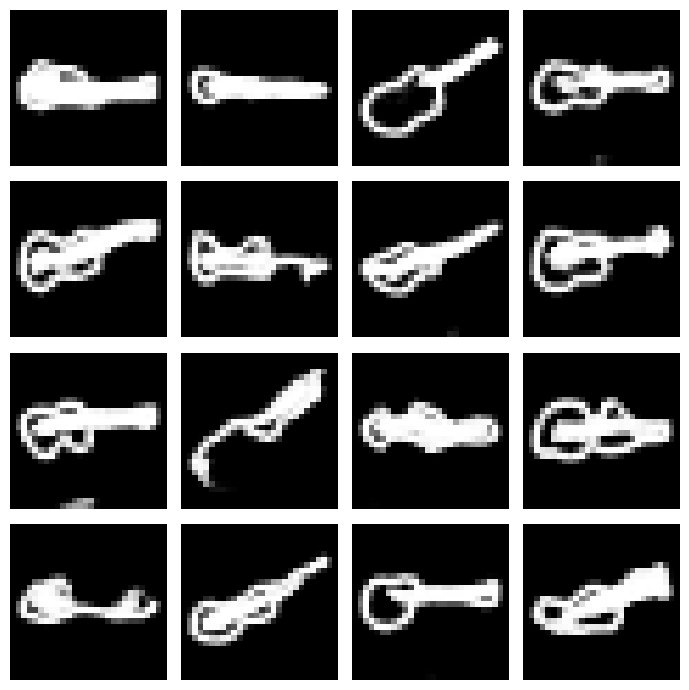

Epoch #9599
9599: [D loss: 0.1725609, acc:0.9140625] [A loss: 2.8619812, acc: 0.0468750]
1/1 [==============================] - 0s 19ms/step


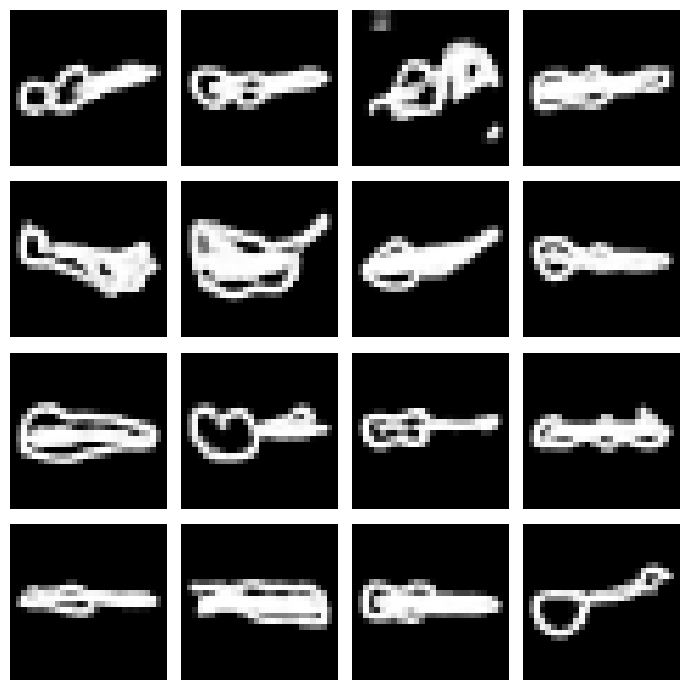

Epoch #9799
9799: [D loss: 0.2096173, acc:0.9140625] [A loss: 2.7941365, acc: 0.0312500]
1/1 [==============================] - 0s 17ms/step


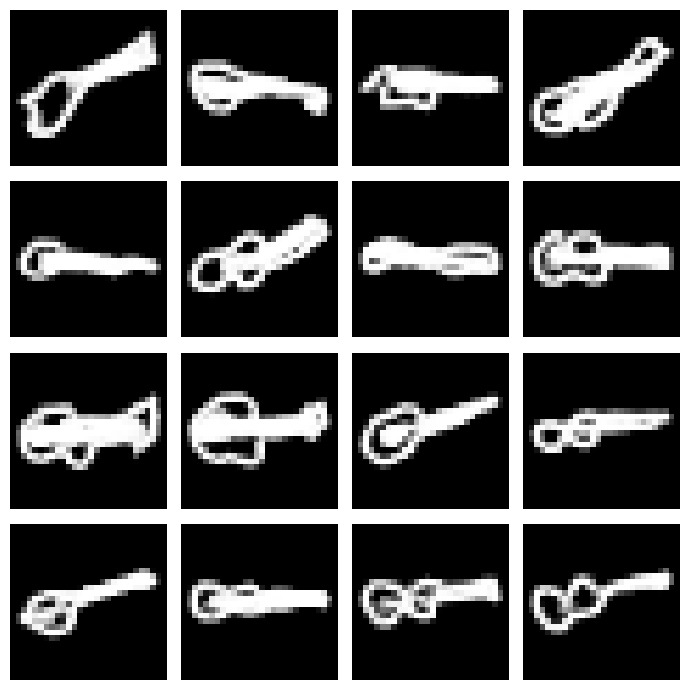

Epoch #9999
9999: [D loss: 0.2002293, acc:0.9218750] [A loss: 3.3751910, acc: 0.0000000]
1/1 [==============================] - 0s 18ms/step


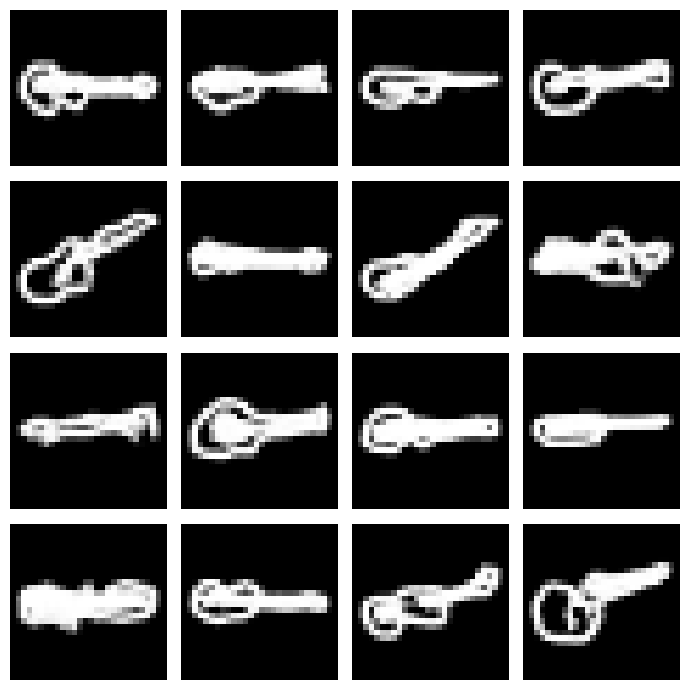

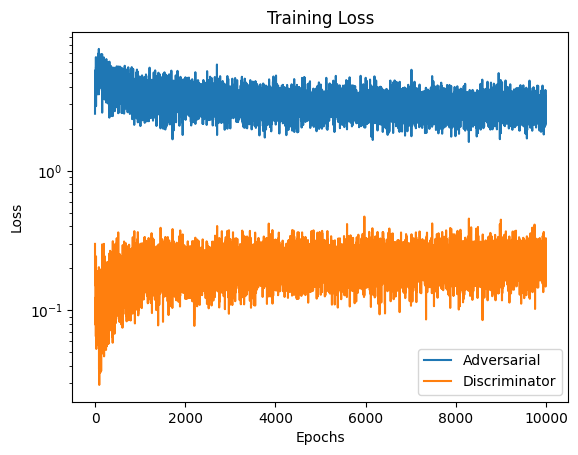

1/1 [==============================] - 0s 144ms/step


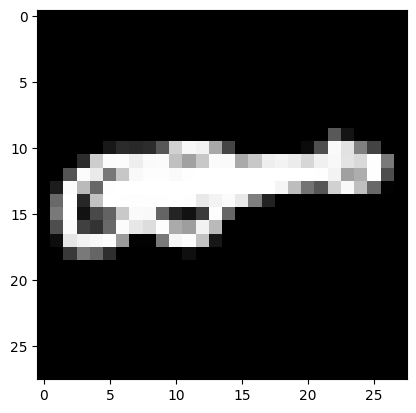

In [14]:
datasets = ["Data/donut.npy","Data/datasets/dolphin.npy", "Data/datasets/guitar.npy"]

datasetname = {
    "Data/donut.npy": "donut",
    "Data/datasets/dolphin.npy": "dolphin",
    "Data/datasets/guitar.npy": "guitar"
}

datasetepochs = {
    "Data/donut.npy": 1400,
    "Data/datasets/dolphin.npy": 10000,
    "Data/datasets/guitar.npy": 10000
}

for dataset in datasets:
    print(f'------------{datasetname[dataset]}-------------')
    # Cargamos el dataset
    data = load_dataset(dataset)
    # Entrenamos el modelo adversario usando el discriminador/generador previamente compilados
    a, d = train_model(data, datasetname[dataset], epochs=datasetepochs[dataset])
    # Se guardan las métricas previamente obtenidas para ser usadas posteriormente de ser necesario
    show_metrics(a, d, datasetname[dataset])
    # Hacemos una prediccion
    make_prediction(datasetname[dataset], epochs=datasetepochs[dataset])